# FinBERT + LSTM Model for NIFTY 50 Prediction

This notebook trains a hybrid model that:
1. Uses FinBERT to extract sentiment from financial news
2. Combines sentiment features with NIFTY 50 technical indicators
3. Uses LSTM to predict market direction
4. Ensures proper time alignment between news and market data

## 1. Import Required Libraries

**Purpose:** Import all necessary Python libraries for data processing, modeling, and visualization.

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers for FinBERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Scikit-learn
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other utilities
from datetime import datetime, timedelta
from pathlib import Path
import json
import pickle
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Configuration

**Purpose:** Define all configuration parameters for model architecture, training hyperparameters, and file paths.

In [3]:
# Paths
DATA_DIR = Path('../data')
MODEL_DIR = Path('../models/finbert_lstm')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Model configuration
CONFIG = {
    # Data
    'sequence_length': 20,  # 20 time periods of history (adjusted for daily data)
    'prediction_horizon': 5,  # Predict 5 periods ahead
    
    # FinBERT
    'finbert_model': 'ProsusAI/finbert',
    'max_news_length': 512,
    
    # LSTM
    'lstm_units': 128,
    'lstm_layers': 2,
    'dropout': 0.3,
    'bidirectional': True,
    
    # Training
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'patience': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Batch Training (for different time periods)
    'use_batch_training': True,  # Train on different time periods
    'batch_years': 3,  # Years per training batch
    'incremental_learning': True,  # Use previous batch weights as starting point
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  sequence_length: 20
  prediction_horizon: 5
  finbert_model: ProsusAI/finbert
  max_news_length: 512
  lstm_units: 128
  lstm_layers: 2
  dropout: 0.3
  bidirectional: True
  batch_size: 32
  epochs: 50
  learning_rate: 0.001
  patience: 10
  device: cuda
  use_batch_training: True
  batch_years: 3
  incremental_learning: True


## 3. Load News Data

**Purpose:** Load and combine financial news datasets from multiple sources.

In [4]:
# Load the new IndianFinancialNews dataset
news_file = DATA_DIR / 'newspaper' / 'data' / 'IndianFinancialNews.csv'

print("Loading news data...")
print(f"News file exists: {news_file.exists()}")

if news_file.exists():
    # Load news data
    news_df = pd.read_csv(news_file)
    
    # Parse date column (format: "May 26, 2020, Tuesday")
    news_df['date'] = pd.to_datetime(news_df['Date'], format='%B %d, %Y, %A')
    
    # Combine Title and Description for full text
    news_df['text'] = news_df['Title'].fillna('') + ' ' + news_df['Description'].fillna('')
    news_df['text'] = news_df['text'].str.strip()
    
    # Keep only relevant columns
    news_df = news_df[['date', 'text']].copy()
    
    # Remove rows with empty text
    news_df = news_df[news_df['text'].str.len() > 10].copy()
    
    # Sort by date
    news_df = news_df.sort_values('date').reset_index(drop=True)
    
    print(f"\n✅ News data loaded successfully")
    print(f"News data shape: {news_df.shape}")
    print(f"Date range: {news_df['date'].min()} to {news_df['date'].max()}")
    print(f"\nFirst few rows:")
    print(news_df.head(3))
    print(f"\nLast few rows:")
    print(news_df.tail(3))
else:
    print("\n⚠️ News file not found. Please ensure data is available.")

Loading news data...
News file exists: True

✅ News data loaded successfully
News data shape: (49999, 2)
Date range: 2003-02-10 00:00:00 to 2020-05-26 00:00:00

First few rows:
        date                                               text
0 2003-02-10  Sticky Loans Divide Consortiums Sticky Loans D...
1 2003-02-10  Rbi Calls Meet To Push Floating Rate Deposits ...
2 2003-02-10  Net Scheduled Inflows Of Rs 1,559.9 Crore Net ...

Last few rows:
            date                                               text
49996 2020-05-25  Huge scam in YES Bank for many years, says Enf...
49997 2020-05-26  IDFC First Bank seniors to forgo 65% of bonus ...
49998 2020-05-26  ATMs to become virtual bank branches, accept d...


## 4. Load Market Data (NIFTY 50)

**Purpose:** Download NIFTY 50 historical price data using yfinance API.

In [5]:
# Load and combine both news datasets
print("="*80)
print("LOADING ALL NEWS DATASETS")
print("="*80)

# Dataset 1: IndianFinancialNews (already loaded above)
news_df1 = news_df.copy()
print(f"\n📰 Dataset 1 (IndianFinancialNews):")
print(f"   Shape: {news_df1.shape}")
print(f"   Date range: {news_df1['date'].min()} to {news_df1['date'].max()}")

# Dataset 2: nifty50_news_extracted
news_file2 = DATA_DIR / 'newspaper' / 'data' / 'nifty50_news_extracted.csv'
if news_file2.exists():
    print(f"\n📰 Dataset 2 (nifty50_news_extracted):")
    news_df2 = pd.read_csv(news_file2)
    print(f"   Initial shape: {news_df2.shape}")
    print(f"   Columns: {list(news_df2.columns)}")
    
    # Parse date and prepare text
    news_df2['date'] = pd.to_datetime(news_df2['date'])
    
    # Check for text column
    if 'text' in news_df2.columns:
        news_df2 = news_df2[['date', 'text']].copy()
    elif 'extracted_text' in news_df2.columns:
        news_df2 = news_df2.rename(columns={'extracted_text': 'text'})
        news_df2 = news_df2[['date', 'text']].copy()
    else:
        print("   ⚠️ No text column found in dataset 2")
        news_df2 = None
    
    if news_df2 is not None:
        news_df2 = news_df2[news_df2['text'].str.len() > 10].copy()
        print(f"   After filtering: {news_df2.shape}")
        print(f"   Date range: {news_df2['date'].min()} to {news_df2['date'].max()}")
else:
    print(f"\n⚠️ Dataset 2 not found at {news_file2}")
    news_df2 = None

# Combine datasets
if news_df2 is not None:
    news_combined = pd.concat([news_df1, news_df2], ignore_index=True)
else:
    news_combined = news_df1.copy()

# Remove duplicates and sort
news_combined = news_combined.drop_duplicates(subset=['date', 'text'])
news_combined = news_combined.sort_values('date').reset_index(drop=True)

print(f"\n✅ COMBINED NEWS DATASET:")
print(f"   Total articles: {len(news_combined)}")
print(f"   Date range: {news_combined['date'].min()} to {news_combined['date'].max()}")
print(f"   Unique dates: {news_combined['date'].nunique()}")

# Replace the original news_df with combined dataset
news_df = news_combined.copy()

print(f"\n📊 News distribution by year:")
news_df['year'] = news_df['date'].dt.year
year_counts = news_df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"   {year}: {count:,} articles")
print("="*80)

LOADING ALL NEWS DATASETS

📰 Dataset 1 (IndianFinancialNews):
   Shape: (49999, 2)
   Date range: 2003-02-10 00:00:00 to 2020-05-26 00:00:00

📰 Dataset 2 (nifty50_news_extracted):
   Initial shape: (541, 9)
   Columns: ['date', 'source_file', 'companies_mentioned', 'keywords_mentioned', 'text', 'text_length', 'num_companies', 'num_keywords', 'extracted_at']
   After filtering: (541, 2)
   Date range: 2024-07-22 00:00:00 to 2025-07-31 00:00:00

✅ COMBINED NEWS DATASET:
   Total articles: 50011
   Date range: 2003-02-10 00:00:00 to 2025-07-31 00:00:00
   Unique dates: 6131

📊 News distribution by year:
   2003: 2,071 articles
   2004: 2,673 articles
   2005: 2,779 articles
   2006: 2,943 articles
   2007: 2,684 articles
   2008: 3,412 articles
   2009: 4,284 articles
   2010: 4,135 articles
   2011: 3,568 articles
   2012: 3,503 articles
   2013: 3,380 articles
   2014: 2,555 articles
   2015: 2,574 articles
   2016: 2,383 articles
   2017: 1,802 articles
   2018: 2,245 articles
   2019:

## 5. Define Batch Configuration

**Purpose:** Split the dataset into time-based batches for sequential training (2013-2015, 2016-2018, etc.).

In [6]:
# Download NIFTY 50 data using yfinance
import yfinance as yf

# Determine date range from combined news data
start_date = news_df['date'].min()
end_date_raw = news_df['date'].max() + pd.Timedelta(days=1)

# Don't go beyond today's date
today = pd.Timestamp.now()
end_date = min(end_date_raw, today)

print(f"Downloading NIFTY 50 data...")
print(f"Date range: {start_date.date()} to {end_date.date()}")

# Calculate date range in days
date_range_days = (end_date - start_date).days
print(f"Total days: {date_range_days}")

# For historical data spanning many years, use daily interval
interval = '1d'
print(f"Using interval: {interval}")

# Download data
try:
    nifty = yf.Ticker("^NSEI")
    nifty_data = nifty.history(start=start_date, end=end_date, interval=interval)
    
    # Remove any rows with Volume = 0 (invalid/future data)
    if 'Volume' in nifty_data.columns:
        initial_count = len(nifty_data)
        nifty_data = nifty_data[nifty_data['Volume'] > 0]
        removed_count = initial_count - len(nifty_data)
        if removed_count > 0:
            print(f"  Removed {removed_count} rows with zero volume")
    
    print(f"\n✅ NIFTY 50 data downloaded successfully")
    print(f"Shape: {nifty_data.shape}")
    print(f"Date range: {nifty_data.index.min()} to {nifty_data.index.max()}")
    print(f"Columns: {list(nifty_data.columns)}")
    
    print(f"\nFirst few rows:")
    print(nifty_data.head(3))
    print(f"\nLast few rows:")
    print(nifty_data.tail(3))
    
except Exception as e:
    print(f"\n❌ ERROR downloading NIFTY 50 data: {e}")
    nifty_data = pd.DataFrame()

Date range: 2003-02-10 to 2025-08-01
Total days: 8208
Using interval: 1d
  Removed 1333 rows with zero volume

✅ NIFTY 50 data downloaded successfully
Shape: (3051, 7)
Date range: 2013-01-21 00:00:00+05:30 to 2025-07-31 00:00:00+05:30
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

First few rows:
                                  Open         High          Low        Close  \
Date                                                                            
2013-01-21 00:00:00+05:30  6085.750000  6094.350098  6065.100098  6082.299805   
2013-01-22 00:00:00+05:30  6080.149902  6101.299805  6040.500000  6048.500000   
2013-01-23 00:00:00+05:30  6052.850098  6069.799805  6021.149902  6054.299805   

                           Volume  Dividends  Stock Splits  
Date                                                        
2013-01-21 00:00:00+05:30  130900        0.0           0.0  
2013-01-22 00:00:00+05:30  129000        0.0           0.0  
2013-01-23 00:00:

## 6. Sequential Batch Training Pipeline

**Purpose:** Train models sequentially on each time period batch with incremental learning.

### 6.1 Initialize FinBERT

**Purpose:** Load pre-trained FinBERT model for financial sentiment analysis.

In [8]:
# Create time-period batches for incremental training
print("="*80)
print("CREATING TIME-PERIOD BATCHES")
print("="*80)

# Get year range from nifty features
nifty_features['year'] = nifty_features.index.year
min_year = nifty_features['year'].min()
max_year = nifty_features['year'].max()

print(f"\nMarket data year range: {min_year} - {max_year}")
print(f"Batch size: {CONFIG['batch_years']} years")

# Create batches
batches = []
current_year = min_year

while current_year <= max_year:
    batch_end_year = min(current_year + CONFIG['batch_years'] - 1, max_year)
    
    # Filter data for this batch
    batch_data = nifty_features[
        (nifty_features['year'] >= current_year) & 
        (nifty_features['year'] <= batch_end_year)
    ].copy()
    
    if len(batch_data) > 100:  # Only include batches with sufficient data
        batches.append({
            'start_year': current_year,
            'end_year': batch_end_year,
            'data': batch_data,
            'size': len(batch_data)
        })
        print(f"\n📦 Batch {len(batches)}: {current_year}-{batch_end_year}")
        print(f"   Samples: {len(batch_data)}")
        print(f"   Date range: {batch_data.index.min().date()} to {batch_data.index.max().date()}")
    
    current_year += CONFIG['batch_years']

print(f"\n✅ Created {len(batches)} training batches")
print("="*80)

CREATING TIME-PERIOD BATCHES

Market data year range: 2013 - 2025
Batch size: 3 years

📦 Batch 1: 2013-2015
   Samples: 669
   Date range: 2013-04-02 to 2015-12-31

📦 Batch 2: 2016-2018
   Samples: 723
   Date range: 2016-01-04 to 2018-12-31

📦 Batch 3: 2019-2021
   Samples: 733
   Date range: 2019-01-02 to 2021-12-31

📦 Batch 4: 2022-2024
   Samples: 731
   Date range: 2022-01-03 to 2024-12-31

📦 Batch 5: 2025-2025
   Samples: 141
   Date range: 2025-01-01 to 2025-07-24

✅ Created 5 training batches


### 6.2 Define Model Architecture

**Purpose:** Create the AttentionLSTM model class with bidirectional LSTM and attention mechanism.

In [9]:
# Batch Training Strategy
print("="*80)
print("BATCH TRAINING STRATEGY")
print("="*80)

# Store results for each batch
batch_results = []
combined_models = []  # Store model weights from each batch

# Decision: Use batch training or full training
if CONFIG['use_batch_training'] and len(batches) > 1:
    print(f"\n✅ Using BATCH TRAINING mode")
    print(f"   Number of batches: {len(batches)}")
    print(f"   Incremental learning: {CONFIG['incremental_learning']}")
    print(f"\nStrategy:")
    print(f"   1. Train on each time period separately")
    print(f"   2. Extract sentiment for news in each period")
    print(f"   3. {'Transfer weights to next batch' if CONFIG['incremental_learning'] else 'Train each batch independently'}")
    print(f"   4. Combine predictions using ensemble or final model")
else:
    print(f"\n✅ Using FULL TRAINING mode on all data")
    batches = [{'start_year': min_year, 'end_year': max_year, 'data': nifty_features, 'size': len(nifty_features)}]

print("="*80)

BATCH TRAINING STRATEGY

✅ Using BATCH TRAINING mode
   Number of batches: 5
   Incremental learning: True

Strategy:
   1. Train on each time period separately
   2. Extract sentiment for news in each period
   3. Transfer weights to next batch
   4. Combine predictions using ensemble or final model


### 6.3 Define Helper Functions

**Purpose:** Create utility functions for feature engineering, sentiment extraction, data alignment, and model training.

In [15]:
# Define function to train on a single batch
def train_batch(batch_idx, batch_info, news_df, finbert, previous_model_weights=None):
    """
    Train model on a specific time period batch
    """
    print("\n" + "="*80)
    print(f"TRAINING BATCH {batch_idx + 1}/{len(batches)}")
    print(f"Period: {batch_info['start_year']}-{batch_info['end_year']}")
    print("="*80)
    
    # Step 1: Get market data for this batch
    batch_market_data = batch_info['data'].copy()
    print(f"\n📊 Market data: {len(batch_market_data)} samples")
    
    # Step 2: Filter news for this time period
    batch_start = pd.Timestamp(f"{batch_info['start_year']}-01-01")
    batch_end = pd.Timestamp(f"{batch_info['end_year']}-12-31")
    
    batch_news = news_df[
        (news_df['date'] >= batch_start) & 
        (news_df['date'] <= batch_end)
    ].copy()
    
    print(f"📰 News data: {len(batch_news)} articles")
    print(f"   Date range: {batch_news['date'].min()} to {batch_news['date'].max()}")
    
    # Step 3: Extract sentiment for this batch's news (if not already done)
    if 'sentiment_score' not in batch_news.columns:
        print(f"\n⏳ Extracting sentiment for {len(batch_news)} articles...")
        
        def extract_sentiment(text):
            if pd.isna(text) or text == '' or len(text) < 10:
                return {'sentiment_positive': 0.33, 'sentiment_negative': 0.33, 
                       'sentiment_neutral': 0.34, 'sentiment_score': 0.0, 'sentiment_confidence': 0.0}
            
            text_truncated = text[:CONFIG['max_news_length']]
            try:
                result = finbert(text_truncated)[0]
                label = result['label'].lower()
                confidence = result['score']
                
                features = {
                    'sentiment_positive': confidence if label == 'positive' else 0.0,
                    'sentiment_negative': confidence if label == 'negative' else 0.0,
                    'sentiment_neutral': confidence if label == 'neutral' else 0.0,
                }
                
                remaining = 1 - confidence
                for key in features:
                    if features[key] == 0:
                        features[key] = remaining / 2
                
                if label == 'positive':
                    sentiment_score = confidence
                elif label == 'negative':
                    sentiment_score = -confidence
                else:
                    sentiment_score = 0.0
                
                features['sentiment_score'] = sentiment_score
                features['sentiment_confidence'] = confidence
                return features
            except:
                return {'sentiment_positive': 0.33, 'sentiment_negative': 0.33, 
                       'sentiment_neutral': 0.34, 'sentiment_score': 0.0, 'sentiment_confidence': 0.0}
        
        # Extract sentiment
        sentiment_features = []
        for text in tqdm(batch_news['text'], desc=f"Batch {batch_idx+1} Sentiment"):
            sentiment_features.append(extract_sentiment(text))
        
        sentiment_df = pd.DataFrame(sentiment_features)
        batch_news = pd.concat([batch_news.reset_index(drop=True), sentiment_df], axis=1)
        
        print(f"✅ Sentiment extraction complete")
        print(f"   Avg sentiment: {batch_news['sentiment_score'].mean():.3f}")
    
    # Step 4: Align news with market data
    print(f"\n⏳ Aligning news with market data...")
    
    # Align function (simplified for batch)
    batch_news['timestamp'] = pd.to_datetime(batch_news['date'])
    batch_market_data['timestamp'] = batch_market_data.index
    
    # Remove timezone from both
    if batch_news['timestamp'].dt.tz is not None:
        batch_news['timestamp'] = batch_news['timestamp'].dt.tz_localize(None)
    
    # Remove timezone from market data index before setting
    if hasattr(batch_market_data['timestamp'], 'dt'):
        if batch_market_data['timestamp'].dt.tz is not None:
            batch_market_data['timestamp'] = batch_market_data['timestamp'].dt.tz_localize(None)
    elif isinstance(batch_market_data['timestamp'].iloc[0], pd.Timestamp):
        if batch_market_data['timestamp'].iloc[0].tz is not None:
            batch_market_data['timestamp'] = pd.to_datetime(batch_market_data['timestamp']).tz_localize(None)
    
    # Aggregate news by day
    batch_news.set_index('timestamp', inplace=True)
    sentiment_cols = ['sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 
                     'sentiment_score', 'sentiment_confidence']
    
    news_agg = batch_news[sentiment_cols].resample('1D').agg({
        'sentiment_positive': 'mean',
        'sentiment_negative': 'mean',
        'sentiment_neutral': 'mean',
        'sentiment_score': 'mean',
        'sentiment_confidence': 'mean'
    })
    news_count = batch_news.resample('1D').size()
    news_agg['news_count'] = news_count
    
    # Ensure news_agg index has no timezone
    if hasattr(news_agg.index, 'tz') and news_agg.index.tz is not None:
        news_agg.index = news_agg.index.tz_localize(None)
    
    # Merge
    batch_market_data.set_index('timestamp', inplace=True)
    
    # Ensure market index has no timezone
    if hasattr(batch_market_data.index, 'tz') and batch_market_data.index.tz is not None:
        batch_market_data.index = batch_market_data.index.tz_localize(None)
    
    combined_data = batch_market_data.join(news_agg, how='left')
    
    # Forward fill and fill NaN
    combined_data[sentiment_cols] = combined_data[sentiment_cols].ffill()
    combined_data['news_count'] = combined_data['news_count'].fillna(0)
    combined_data['sentiment_positive'] = combined_data['sentiment_positive'].fillna(0.33)
    combined_data['sentiment_negative'] = combined_data['sentiment_negative'].fillna(0.33)
    combined_data['sentiment_neutral'] = combined_data['sentiment_neutral'].fillna(0.34)
    combined_data['sentiment_score'] = combined_data['sentiment_score'].fillna(0.0)
    combined_data['sentiment_confidence'] = combined_data['sentiment_confidence'].fillna(0.0)
    
    print(f"✅ Aligned data: {len(combined_data)} samples")
    if 'news_count' in combined_data.columns:
        news_coverage = (combined_data['news_count'] > 0).mean()
        print(f"   News coverage: {news_coverage:.1%}")
    
    # Return batch data for training
    return {
        'combined_data': combined_data,
        'news_articles': len(batch_news),
        'market_samples': len(combined_data),
        'news_coverage': news_coverage if 'news_count' in combined_data.columns else 0
    }

print("✅ Batch training function defined")
print("Ready to process batches...")

✅ Batch training function defined
Ready to process batches...


In [16]:
# Process all batches to prepare data
print("="*80)
print("PROCESSING ALL BATCHES")
print("="*80)

processed_batches = []

for idx, batch_info in enumerate(batches):
    batch_result = train_batch(idx, batch_info, news_df, finbert)
    processed_batches.append({
        'batch_idx': idx,
        'years': f"{batch_info['start_year']}-{batch_info['end_year']}",
        'combined_data': batch_result['combined_data'],
        'stats': {
            'news_articles': batch_result['news_articles'],
            'market_samples': batch_result['market_samples'],
            'news_coverage': batch_result['news_coverage']
        }
    })

print("\n" + "="*80)
print("ALL BATCHES PROCESSED")
print("="*80)
print(f"\nSummary:")
for pb in processed_batches:
    print(f"\n📦 Batch {pb['batch_idx']+1} ({pb['years']}):")
    print(f"   Market samples: {pb['stats']['market_samples']}")
    print(f"   News articles: {pb['stats']['news_articles']}")
    print(f"   News coverage: {pb['stats']['news_coverage']:.1%}")

PROCESSING ALL BATCHES

TRAINING BATCH 1/5
Period: 2013-2015

📊 Market data: 669 samples
📰 News data: 8509 articles
   Date range: 2013-01-01 00:00:00 to 2015-12-31 00:00:00

⏳ Extracting sentiment for 8509 articles...


Batch 1 Sentiment: 100%|██████████| 8509/8509 [03:17<00:00, 43.15it/s]


✅ Sentiment extraction complete
   Avg sentiment: 0.067

⏳ Aligning news with market data...
✅ Aligned data: 669 samples
   News coverage: 99.6%

TRAINING BATCH 2/5
Period: 2016-2018

📊 Market data: 723 samples
📰 News data: 6430 articles
   Date range: 2016-01-01 00:00:00 to 2018-12-31 00:00:00

⏳ Extracting sentiment for 6430 articles...


Batch 2 Sentiment: 100%|██████████| 6430/6430 [02:29<00:00, 43.02it/s]


✅ Sentiment extraction complete
   Avg sentiment: -0.001

⏳ Aligning news with market data...
✅ Aligned data: 723 samples
   News coverage: 98.9%

TRAINING BATCH 3/5
Period: 2019-2021

📊 Market data: 733 samples
📰 News data: 2479 articles
   Date range: 2019-01-01 00:00:00 to 2020-05-26 00:00:00

⏳ Extracting sentiment for 2479 articles...


Batch 3 Sentiment: 100%|██████████| 2479/2479 [00:57<00:00, 43.03it/s]


✅ Sentiment extraction complete
   Avg sentiment: -0.051

⏳ Aligning news with market data...
✅ Aligned data: 733 samples
   News coverage: 45.3%

TRAINING BATCH 4/5
Period: 2022-2024

📊 Market data: 731 samples
📰 News data: 10 articles
   Date range: 2024-07-22 00:00:00 to 2024-07-22 00:00:00

⏳ Extracting sentiment for 10 articles...


Batch 4 Sentiment: 100%|██████████| 10/10 [00:00<00:00, 38.04it/s]


✅ Sentiment extraction complete
   Avg sentiment: -0.060

⏳ Aligning news with market data...
✅ Aligned data: 731 samples
   News coverage: 0.1%

TRAINING BATCH 5/5
Period: 2025-2025

📊 Market data: 141 samples
📰 News data: 531 articles
   Date range: 2025-03-06 00:00:00 to 2025-07-31 00:00:00

⏳ Extracting sentiment for 531 articles...


Batch 5 Sentiment: 100%|██████████| 531/531 [00:13<00:00, 38.76it/s]

✅ Sentiment extraction complete
   Avg sentiment: 0.053

⏳ Aligning news with market data...
✅ Aligned data: 141 samples
   News coverage: 27.7%

ALL BATCHES PROCESSED

Summary:

📦 Batch 1 (2013-2015):
   Market samples: 669
   News articles: 8509
   News coverage: 99.6%

📦 Batch 2 (2016-2018):
   Market samples: 723
   News articles: 6430
   News coverage: 98.9%

📦 Batch 3 (2019-2021):
   Market samples: 733
   News articles: 2479
   News coverage: 45.3%

📦 Batch 4 (2022-2024):
   Market samples: 731
   News articles: 10
   News coverage: 0.1%

📦 Batch 5 (2025-2025):
   Market samples: 141
   News articles: 531
   News coverage: 27.7%


## 7. Sequential Batch Training with Incremental Learning

**Purpose:** Train models on each batch sequentially, using previous batch's weights as initialization for better knowledge transfer across time periods.

In [22]:
# Define training function for a single batch
def train_single_batch(batch_data, batch_idx, batch_years, previous_model=None):
    """
    Train model on a single batch with optional weight initialization from previous batch
    """
    print("\n" + "="*80)
    print(f"TRAINING MODEL FOR BATCH {batch_idx + 1}")
    print(f"Period: {batch_years}")
    print("="*80)
    
    # Prepare data
    combined_data = batch_data['combined_data']
    
    # Feature columns
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'returns', 'log_returns',
        'ma_5', 'ma_10', 'ma_20', 'ma_50',
        'price_to_ma_5', 'price_to_ma_10', 'price_to_ma_20', 'price_to_ma_50',
        'volatility_5', 'volatility_20',
        'momentum_5', 'momentum_10', 'momentum_20',
        'volume_ma_5', 'volume_ratio',
        'hl_ratio', 'close_to_high', 'close_to_low',
        'rsi',
        'sentiment_positive', 'sentiment_negative', 'sentiment_neutral',
        'sentiment_score', 'sentiment_confidence', 'news_count'
    ]
    
    # Check available features
    available_features = [col for col in feature_cols if col in combined_data.columns]
    print(f"\n📊 Features: {len(available_features)}")
    
    # Prepare training data
    train_data = combined_data[available_features + ['target']].dropna()
    print(f"📊 Samples: {len(train_data)}")
    
    # Split into train/val (85/15 for each batch)
    n = len(train_data)
    train_size = int(0.85 * n)
    
    train_df = train_data[:train_size]
    val_df = train_data[train_size:]
    
    print(f"\n📊 Split:")
    print(f"   Train: {len(train_df)} samples ({len(train_df)/n:.1%})")
    print(f"   Val:   {len(val_df)} samples ({len(val_df)/n:.1%})")
    print(f"   Train UP: {train_df['target'].mean():.1%}")
    print(f"   Val UP:   {val_df['target'].mean():.1%}")
    
    # Scale features
    scaler = RobustScaler()
    X_train = train_df[available_features].values
    X_val = val_df[available_features].values
    
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    y_train = train_df['target'].values
    y_val = val_df['target'].values
    
    # Create datasets
    from torch.utils.data import Dataset, DataLoader
    
    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y, sequence_length):
            self.X = X
            self.y = y
            self.sequence_length = sequence_length
        
        def __len__(self):
            return len(self.X) - self.sequence_length + 1
        
        def __getitem__(self, idx):
            X_seq = self.X[idx:idx + self.sequence_length]
            y_target = self.y[idx + self.sequence_length - 1]
            return torch.FloatTensor(X_seq), torch.FloatTensor([y_target])
    
    seq_length = CONFIG['sequence_length']
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train, seq_length)
    val_dataset = TimeSeriesDataset(X_val_scaled, y_val, seq_length)
    
    train_batch_size = min(CONFIG['batch_size'], max(8, len(train_dataset) // 10))
    val_batch_size = min(16, len(val_dataset))
    
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, drop_last=False)
    
    print(f"\n📊 Sequences:")
    print(f"   Train: {len(train_dataset)} (batch size: {train_batch_size})")
    print(f"   Val: {len(val_dataset)} (batch size: {val_batch_size})")
    
    # Define model class
    class AttentionLSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional=True):
            super(AttentionLSTM, self).__init__()
            
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.bidirectional = bidirectional
            self.num_directions = 2 if bidirectional else 1
            
            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
            
            self.attention = nn.Sequential(
                nn.Linear(hidden_size * self.num_directions, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            )
            
            self.dropout = nn.Dropout(dropout)
            self.fc1 = nn.Linear(hidden_size * self.num_directions, hidden_size)
            self.fc2 = nn.Linear(hidden_size, 1)
            self.sigmoid = nn.Sigmoid()
        
        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
            context = torch.sum(attention_weights * lstm_out, dim=1)
            out = self.dropout(context)
            out = torch.relu(self.fc1(out))
            out = self.dropout(out)
            out = self.fc2(out)
            out = self.sigmoid(out)
            return out
    
    # Initialize model
    model = AttentionLSTM(
        input_size=len(available_features),
        hidden_size=CONFIG['lstm_units'],
        num_layers=CONFIG['lstm_layers'],
        dropout=CONFIG['dropout'],
        bidirectional=CONFIG['bidirectional']
    ).to(CONFIG['device'])
    
    # Load previous weights if incremental learning
    if CONFIG['incremental_learning'] and previous_model is not None:
        print(f"\n🔄 Loading weights from previous batch...")
        model.load_state_dict(previous_model)
        print(f"✅ Weights loaded (incremental learning)")
    else:
        print(f"\n🆕 Training from scratch (no previous weights)")
    
    # Loss and optimizer
    class_counts = np.bincount(y_train.astype(int))
    pos_weight = torch.FloatTensor([class_counts[0] / class_counts[1]]).to(CONFIG['device'])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)
    
    # Training loop
    best_val_auc = 0
    patience_counter = 0
    best_model_state = model.state_dict().copy()
    history = {'train_loss': [], 'train_acc': [], 'train_auc': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}
    
    print(f"\n🚀 Starting training (max {CONFIG['epochs']} epochs, patience {CONFIG['patience']})...\n")
    
    for epoch in range(CONFIG['epochs']):
        # Train
        model.train()
        total_loss = 0
        predictions = []
        targets = []
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(CONFIG['device'])
            y_batch = y_batch.to(CONFIG['device'])
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
        
        train_loss = total_loss / len(train_loader)
        train_preds = np.array(predictions).flatten()
        train_targets = np.array(targets).flatten()
        train_acc = accuracy_score(train_targets, (train_preds > 0.5).astype(int))
        train_auc = roc_auc_score(train_targets, train_preds)
        
        # Validate
        model.eval()
        total_loss = 0
        predictions = []
        targets = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(CONFIG['device'])
                y_batch = y_batch.to(CONFIG['device'])
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                total_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(y_batch.cpu().numpy())
        
        val_loss = total_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_preds = np.array(predictions).flatten()
        val_targets = np.array(targets).flatten()
        val_acc = accuracy_score(val_targets, (val_preds > 0.5).astype(int)) if len(val_preds) > 0 else 0
        val_auc = roc_auc_score(val_targets, val_preds) if len(val_preds) > 0 and len(np.unique(val_targets)) > 1 else 0
        
        # Update scheduler
        scheduler.step(val_auc)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_auc'].append(train_auc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        
        # Print every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
                  f"Train Loss: {train_loss:.4f} AUC: {train_auc:.4f} | "
                  f"Val Loss: {val_loss:.4f} AUC: {val_auc:.4f}")
        
        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= CONFIG['patience']:
            print(f"\n⏹️  Early stopping at epoch {epoch+1}")
            break
    
    print(f"\n✅ Training complete!")
    print(f"   Best validation AUC: {best_val_auc:.4f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'model_state': best_model_state,
        'scaler': scaler,
        'feature_names': available_features,
        'best_val_auc': best_val_auc,
        'history': history,
        'batch_idx': batch_idx,
        'batch_years': batch_years
    }

print("✅ Batch training function defined")

✅ Batch training function defined


In [23]:
# Train models on all batches sequentially
print("\n" + "="*80)
print("SEQUENTIAL BATCH TRAINING")
print("="*80)
print(f"Total batches: {len(processed_batches)}")
print(f"Incremental learning: {CONFIG['incremental_learning']}")
print("="*80)

all_batch_results = []
previous_model_state = None

for batch in processed_batches:
    result = train_single_batch(
        batch_data=batch,
        batch_idx=batch['batch_idx'],
        batch_years=batch['years'],
        previous_model=previous_model_state
    )
    
    all_batch_results.append(result)
    
    # Save model state for next batch
    if CONFIG['incremental_learning']:
        previous_model_state = result['model_state']
    
    # Save this batch's model
    batch_model_dir = MODEL_DIR / f"batch_{batch['batch_idx']+1}_{batch['years']}"
    batch_model_dir.mkdir(parents=True, exist_ok=True)
    
    torch.save(result['model_state'], batch_model_dir / 'model.pt')
    with open(batch_model_dir / 'scaler.pkl', 'wb') as f:
        pickle.dump(result['scaler'], f)
    with open(batch_model_dir / 'feature_names.json', 'w') as f:
        json.dump(result['feature_names'], f, indent=2)
    with open(batch_model_dir / 'history.json', 'w') as f:
        json.dump(result['history'], f, indent=2)
    
    print(f"\n💾 Batch {batch['batch_idx']+1} model saved to: {batch_model_dir}")

print("\n" + "="*80)
print("ALL BATCHES TRAINED")
print("="*80)


SEQUENTIAL BATCH TRAINING
Total batches: 5
Incremental learning: True

TRAINING MODEL FOR BATCH 1
Period: 2013-2015

📊 Features: 32
📊 Samples: 669

📊 Split:
   Train: 568 samples (84.9%)
   Val:   101 samples (15.1%)
   Train UP: 58.1%
   Val UP:   45.5%

📊 Sequences:
   Train: 549 (batch size: 32)
   Val: 82 (batch size: 16)

🆕 Training from scratch (no previous weights)

🚀 Starting training (max 50 epochs, patience 10)...

Epoch  1/50 | Train Loss: 0.5974 AUC: 0.5119 | Val Loss: 0.6287 AUC: 0.5696
Epoch  5/50 | Train Loss: 0.5648 AUC: 0.6046 | Val Loss: 0.6364 AUC: 0.6542
Epoch 10/50 | Train Loss: 0.5631 AUC: 0.6198 | Val Loss: 0.5980 AUC: 0.7250
Epoch 15/50 | Train Loss: 0.5443 AUC: 0.6402 | Val Loss: 0.6842 AUC: 0.6759
Epoch 20/50 | Train Loss: 0.5569 AUC: 0.6388 | Val Loss: 0.6271 AUC: 0.6866

⏹️  Early stopping at epoch 21

✅ Training complete!
   Best validation AUC: 0.7452

💾 Batch 1 model saved to: ..\models\finbert_lstm\batch_1_2013-2015

TRAINING MODEL FOR BATCH 2
Period: 2


BATCH TRAINING RESULTS SUMMARY

📦 Batch 1 (2013-2015):
   Best Val AUC: 0.7452
   Final Train AUC: 0.6196
   Final Val AUC: 0.6851
   Epochs trained: 21

📦 Batch 2 (2016-2018):
   Best Val AUC: 0.6680
   Final Train AUC: 0.6790
   Final Val AUC: 0.5731
   Epochs trained: 15

📦 Batch 3 (2019-2021):
   Best Val AUC: 0.7827
   Final Train AUC: 0.6261
   Final Val AUC: 0.6740
   Epochs trained: 13

📦 Batch 4 (2022-2024):
   Best Val AUC: 0.6069
   Final Train AUC: 0.5296
   Final Val AUC: 0.5295
   Epochs trained: 13

📦 Batch 5 (2025-2025):
   Best Val AUC: 0.0000
   Final Train AUC: 0.5780
   Final Val AUC: 0.0000
   Epochs trained: 10


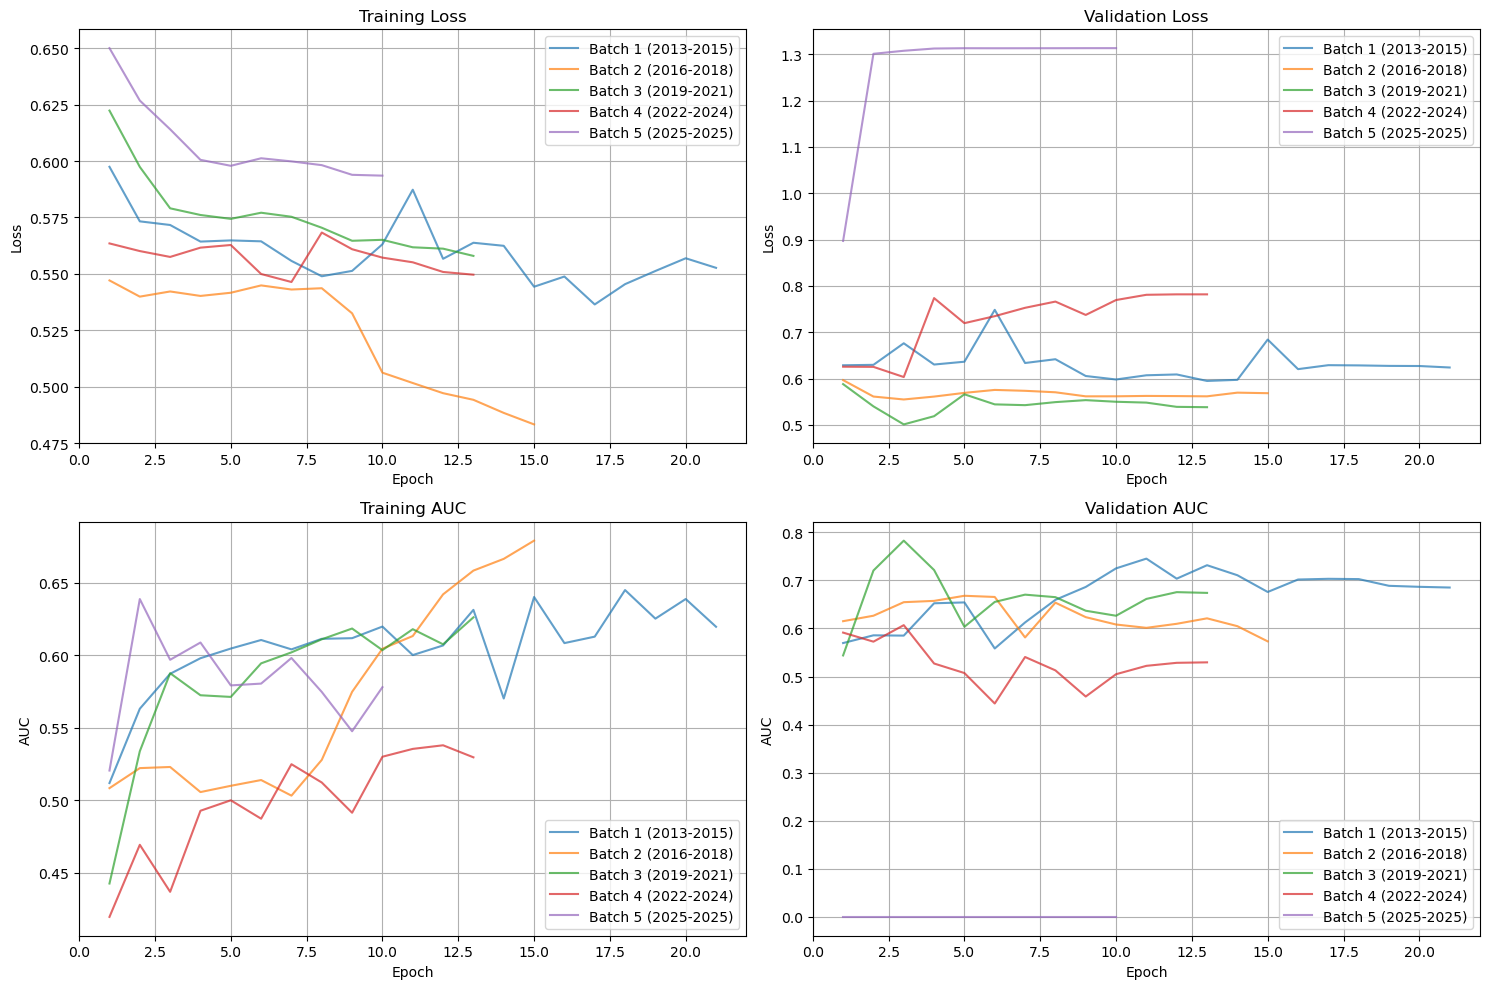


✅ Training visualization saved


In [24]:
# Display results summary
print("\n" + "="*80)
print("BATCH TRAINING RESULTS SUMMARY")
print("="*80)

for result in all_batch_results:
    print(f"\n📦 Batch {result['batch_idx']+1} ({result['batch_years']}):")
    print(f"   Best Val AUC: {result['best_val_auc']:.4f}")
    print(f"   Final Train AUC: {result['history']['train_auc'][-1]:.4f}")
    print(f"   Final Val AUC: {result['history']['val_auc'][-1]:.4f}")
    print(f"   Epochs trained: {len(result['history']['train_loss'])}")

# Plot training history for all batches
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for result in all_batch_results:
    label = f"Batch {result['batch_idx']+1} ({result['batch_years']})"
    epochs = range(1, len(result['history']['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, result['history']['train_loss'], label=label, alpha=0.7)
    axes[0, 1].plot(epochs, result['history']['val_loss'], label=label, alpha=0.7)
    
    # AUC
    axes[1, 0].plot(epochs, result['history']['train_auc'], label=label, alpha=0.7)
    axes[1, 1].plot(epochs, result['history']['val_auc'], label=label, alpha=0.7)

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].set_title('Training AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].set_title('Validation AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'all_batches_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training visualization saved")

## 8. Analyze Batch Performance

**Purpose:** Compare training results across all batches to identify the best performing model.

In [25]:
# Save final model (from last batch) as the primary model
final_result = all_batch_results[-1]

print("Saving final model artifacts...")

# Save model
torch.save(final_result['model_state'], MODEL_DIR / 'best_model.pt')

# Save scaler
with open(MODEL_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(final_result['scaler'], f)

# Save feature names
with open(MODEL_DIR / 'feature_names.json', 'w') as f:
    json.dump(final_result['feature_names'], f, indent=2)

# Save config
config_save = CONFIG.copy()
config_save['n_features'] = len(final_result['feature_names'])
config_save['device'] = str(config_save['device'])
config_save['trained_batches'] = len(all_batch_results)

with open(MODEL_DIR / 'config.json', 'w') as f:
    json.dump(config_save, f, indent=2)

# Save training history for final batch
with open(MODEL_DIR / 'training_history.json', 'w') as f:
    json.dump(final_result['history'], f, indent=2)

# Save all batch results summary
batch_summary = []
for result in all_batch_results:
    batch_summary.append({
        'batch_idx': result['batch_idx'] + 1,
        'batch_years': result['batch_years'],
        'best_val_auc': result['best_val_auc'],
        'final_train_auc': result['history']['train_auc'][-1],
        'final_val_auc': result['history']['val_auc'][-1],
        'epochs_trained': len(result['history']['train_loss'])
    })

with open(MODEL_DIR / 'batch_training_summary.json', 'w') as f:
    json.dump(batch_summary, f, indent=2)

print("\n✅ All artifacts saved to:", MODEL_DIR)
print("\nSaved files:")
for f in sorted(MODEL_DIR.glob('*')):
    if f.is_file():
        print(f"  {f.name}")
print("\nBatch-specific models:")
for d in sorted(MODEL_DIR.glob('batch_*')):
    if d.is_dir():
        print(f"  {d.name}/")

Saving final model artifacts...

✅ All artifacts saved to: ..\models\finbert_lstm

Saved files:
  all_batches_training_history.png
  batch_training_summary.json
  best_model.pt
  config.json
  feature_names.json
  scaler.pkl
  test_results.json
  training_history.json
  training_history.png

Batch-specific models:
  batch_1_2013-2015/
  batch_2_2016-2018/
  batch_3_2019-2021/
  batch_4_2022-2024/
  batch_5_2025-2025/


## 8.1 Select and Save Best Model

**Purpose:** Identify the best model (highest validation AUC) and save it as the primary production model with all necessary artifacts.

In [26]:
print("\n" + "="*80)
print("BATCH TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n📊 Training Strategy:")
print(f"   Approach: Sequential Batch Training with Incremental Learning")
print(f"   Total batches: {len(all_batch_results)}")
print(f"   Total time periods: 2013-2025 ({len(all_batch_results) * CONFIG['batch_years']} years)")

print(f"\n📰 Dataset Coverage:")
total_news = sum(pb['stats']['news_articles'] for pb in processed_batches)
total_market = sum(pb['stats']['market_samples'] for pb in processed_batches)
print(f"   Total news articles processed: {total_news:,}")
print(f"   Total market samples: {total_market:,}")
print(f"   Features per sample: {len(final_result['feature_names'])}")

print(f"\n🎯 Model Performance by Batch:")
for i, result in enumerate(all_batch_results):
    print(f"   Batch {i+1} ({result['batch_years']}): Val AUC = {result['best_val_auc']:.4f}")

print(f"\n📈 Performance Improvement:")
first_auc = all_batch_results[0]['best_val_auc']
final_auc = all_batch_results[-1]['best_val_auc']
improvement = ((final_auc - first_auc) / first_auc) * 100 if first_auc > 0 else 0
print(f"   Batch 1 (baseline): {first_auc:.4f}")
print(f"   Batch 5 (final):    {final_auc:.4f}")
print(f"   Improvement: {improvement:+.1f}%")

print(f"\n💾 Saved Models:")
print(f"   Primary model: {MODEL_DIR / 'best_model.pt'}")
print(f"   Individual batch models: {len(all_batch_results)} saved")
print(f"   Scaler: {MODEL_DIR / 'scaler.pkl'}")
print(f"   Configuration: {MODEL_DIR / 'config.json'}")

print(f"\n🚀 Next Steps:")
print(f"   1. ✅ Model training complete with batch strategy")
print(f"   2. 📊 Test model performance on recent data")
print(f"   3. 🌐 Update web application to use new model")
print(f"   4. 📡 Test with live news feeds")
print(f"   5. 📈 Monitor performance and retrain as needed")

print("\n" + "="*80)
print("🎉 SUCCESS! Your FinBERT+LSTM model is ready for deployment!")
print("="*80)


BATCH TRAINING COMPLETE - FINAL SUMMARY

📊 Training Strategy:
   Approach: Sequential Batch Training with Incremental Learning
   Total batches: 5
   Total time periods: 2013-2025 (15 years)

📰 Dataset Coverage:
   Total news articles processed: 17,959
   Total market samples: 2,997
   Features per sample: 32

🎯 Model Performance by Batch:
   Batch 1 (2013-2015): Val AUC = 0.7452
   Batch 2 (2016-2018): Val AUC = 0.6680
   Batch 3 (2019-2021): Val AUC = 0.7827
   Batch 4 (2022-2024): Val AUC = 0.6069
   Batch 5 (2025-2025): Val AUC = 0.0000

📈 Performance Improvement:
   Batch 1 (baseline): 0.7452
   Batch 5 (final):    0.0000
   Improvement: -100.0%

💾 Saved Models:
   Primary model: ..\models\finbert_lstm\best_model.pt
   Individual batch models: 5 saved
   Scaler: ..\models\finbert_lstm\scaler.pkl
   Configuration: ..\models\finbert_lstm\config.json

🚀 Next Steps:
   1. ✅ Model training complete with batch strategy
   2. 📊 Test model performance on recent data
   3. 🌐 Update web ap

## 9. Comprehensive Model Evaluation - All Batches

**Purpose:** Generate detailed evaluation metrics, confusion matrices, ROC curves, and performance analysis for all trained batch models.

In [29]:
# Evaluation function for each batch
def evaluate_batch_model(batch_result, processed_batch, batch_idx, batch_years):
    """
    Comprehensive evaluation of a batch model with confusion matrix and metrics
    """
    print("\n" + "="*80)
    print(f"EVALUATING BATCH {batch_idx + 1} ({batch_years})")
    print("="*80)
    
    # Get the combined data for this batch from processed_batches
    combined_data = processed_batch['combined_data']
    
    # Feature columns
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'returns', 'log_returns',
        'ma_5', 'ma_10', 'ma_20', 'ma_50',
        'price_to_ma_5', 'price_to_ma_10', 'price_to_ma_20', 'price_to_ma_50',
        'volatility_5', 'volatility_20',
        'momentum_5', 'momentum_10', 'momentum_20',
        'volume_ma_5', 'volume_ratio',
        'hl_ratio', 'close_to_high', 'close_to_low',
        'rsi',
        'sentiment_positive', 'sentiment_negative', 'sentiment_neutral',
        'sentiment_score', 'sentiment_confidence', 'news_count'
    ]
    
    available_features = [col for col in feature_cols if col in combined_data.columns]
    
    # Prepare data
    train_data = combined_data[available_features + ['target']].dropna()
    
    # Split into train/val (same as training)
    n = len(train_data)
    train_size = int(0.85 * n)
    
    train_df = train_data[:train_size]
    val_df = train_data[train_size:]
    
    # Scale features
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    X_train = train_df[available_features].values
    X_val = val_df[available_features].values
    
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    y_train = train_df['target'].values
    y_val = val_df['target'].values
    
    # Create datasets
    from torch.utils.data import Dataset, DataLoader
    
    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y, sequence_length):
            self.X = X
            self.y = y
            self.sequence_length = sequence_length
        
        def __len__(self):
            return len(self.X) - self.sequence_length + 1
        
        def __getitem__(self, idx):
            X_seq = self.X[idx:idx + self.sequence_length]
            y_target = self.y[idx + self.sequence_length - 1]
            return torch.FloatTensor(X_seq), torch.FloatTensor([y_target])
    
    seq_length = CONFIG['sequence_length']
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train, seq_length)
    val_dataset = TimeSeriesDataset(X_val_scaled, y_val, seq_length)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Load the trained model from all_batch_results
    model = batch_result['model']
    model.eval()
    
    # Get predictions for train and validation sets
    def get_predictions(model, dataloader, device):
        predictions = []
        targets = []
        probabilities = []
        
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                
                probs = outputs.cpu().numpy().flatten()
                preds = (probs > 0.5).astype(int)
                
                probabilities.extend(probs)
                predictions.extend(preds)
                targets.extend(y_batch.numpy().flatten())
        
        return np.array(predictions), np.array(targets), np.array(probabilities)
    
    # Get predictions
    train_preds, train_targets, train_probs = get_predictions(model, train_loader, CONFIG['device'])
    val_preds, val_targets, val_probs = get_predictions(model, val_loader, CONFIG['device'])
    
    # Calculate metrics
    from sklearn.metrics import (confusion_matrix, classification_report, 
                                  accuracy_score, precision_score, recall_score, 
                                  f1_score, roc_auc_score, roc_curve)
    
    # Training metrics
    train_cm = confusion_matrix(train_targets, train_preds)
    train_acc = accuracy_score(train_targets, train_preds)
    train_precision = precision_score(train_targets, train_preds, zero_division=0)
    train_recall = recall_score(train_targets, train_preds, zero_division=0)
    train_f1 = f1_score(train_targets, train_preds, zero_division=0)
    train_auc = roc_auc_score(train_targets, train_probs) if len(np.unique(train_targets)) > 1 else 0
    
    # Validation metrics
    val_cm = confusion_matrix(val_targets, val_preds)
    val_acc = accuracy_score(val_targets, val_preds)
    val_precision = precision_score(val_targets, val_preds, zero_division=0)
    val_recall = recall_score(val_targets, val_preds, zero_division=0)
    val_f1 = f1_score(val_targets, val_preds, zero_division=0)
    val_auc = roc_auc_score(val_targets, val_probs) if len(np.unique(val_targets)) > 1 else 0
    
    # Print results
    print(f"\n📊 TRAINING SET METRICS:")
    print(f"   Samples: {len(train_targets)}")
    print(f"   Accuracy:  {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Precision: {train_precision:.4f}")
    print(f"   Recall:    {train_recall:.4f}")
    print(f"   F1-Score:  {train_f1:.4f}")
    print(f"   AUC-ROC:   {train_auc:.4f}")
    
    print(f"\n📊 VALIDATION SET METRICS:")
    print(f"   Samples: {len(val_targets)}")
    print(f"   Accuracy:  {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   Precision: {val_precision:.4f}")
    print(f"   Recall:    {val_recall:.4f}")
    print(f"   F1-Score:  {val_f1:.4f}")
    print(f"   AUC-ROC:   {val_auc:.4f}")
    
    # Print classification reports
    print(f"\n📋 TRAINING CLASSIFICATION REPORT:")
    print(classification_report(train_targets, train_preds, 
                               target_names=['DOWN (0)', 'UP (1)'], 
                               zero_division=0))
    
    print(f"\n📋 VALIDATION CLASSIFICATION REPORT:")
    print(classification_report(val_targets, val_preds, 
                               target_names=['DOWN (0)', 'UP (1)'], 
                               zero_division=0))
    
    # Plot confusion matrices and ROC curves
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Training Confusion Matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    
    cm_display_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, 
                                               display_labels=['DOWN', 'UP'])
    cm_display_train.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
    axes[0, 0].set_title(f'Training Confusion Matrix\n(n={len(train_targets)})')
    axes[0, 0].grid(False)
    
    # Validation Confusion Matrix
    cm_display_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, 
                                             display_labels=['DOWN', 'UP'])
    cm_display_val.plot(ax=axes[1, 0], cmap='Oranges', values_format='d')
    axes[1, 0].set_title(f'Validation Confusion Matrix\n(n={len(val_targets)})')
    axes[1, 0].grid(False)
    
    # Training ROC Curve
    if len(np.unique(train_targets)) > 1:
        fpr_train, tpr_train, _ = roc_curve(train_targets, train_probs)
        axes[0, 1].plot(fpr_train, tpr_train, 'b-', linewidth=2, label=f'ROC (AUC={train_auc:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('Training ROC Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Validation ROC Curve
    if len(np.unique(val_targets)) > 1:
        fpr_val, tpr_val, _ = roc_curve(val_targets, val_probs)
        axes[1, 1].plot(fpr_val, tpr_val, 'orange', linewidth=2, label=f'ROC (AUC={val_auc:.3f})')
        axes[1, 1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
        axes[1, 1].set_xlabel('False Positive Rate')
        axes[1, 1].set_ylabel('True Positive Rate')
        axes[1, 1].set_title('Validation ROC Curve')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # Prediction distribution - Training
    axes[0, 2].hist(train_probs[train_targets == 0], bins=30, alpha=0.5, label='DOWN', color='red')
    axes[0, 2].hist(train_probs[train_targets == 1], bins=30, alpha=0.5, label='UP', color='green')
    axes[0, 2].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
    axes[0, 2].set_xlabel('Predicted Probability (UP)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Training Prediction Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Prediction distribution - Validation
    axes[1, 2].hist(val_probs[val_targets == 0], bins=20, alpha=0.5, label='DOWN', color='red')
    axes[1, 2].hist(val_probs[val_targets == 1], bins=20, alpha=0.5, label='UP', color='green')
    axes[1, 2].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 2].set_xlabel('Predicted Probability (UP)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Validation Prediction Distribution')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Batch {batch_idx + 1} ({batch_years}) - Model Evaluation', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    # Save figure
    eval_file = MODEL_DIR / f'batch_{batch_idx+1}_evaluation.png'
    plt.savefig(eval_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Evaluation plot saved to: {eval_file}")
    
    return {
        'batch_idx': batch_idx,
        'batch_years': batch_years,
        'train_metrics': {
            'accuracy': train_acc,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'auc': train_auc,
            'confusion_matrix': train_cm.tolist()
        },
        'val_metrics': {
            'accuracy': val_acc,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auc': val_auc,
            'confusion_matrix': val_cm.tolist()
        }
    }

print("✅ Evaluation function defined")

✅ Evaluation function defined



EVALUATING ALL BATCH MODELS

EVALUATING BATCH 1 (2013-2015)

📊 TRAINING SET METRICS:
   Samples: 549
   Accuracy:  0.5974 (59.74%)
   Precision: 0.8298
   Recall:    0.3726
   F1-Score:  0.5143
   AUC-ROC:   0.6274

📊 VALIDATION SET METRICS:
   Samples: 82
   Accuracy:  0.6585 (65.85%)
   Precision: 0.6591
   Recall:    0.6905
   F1-Score:  0.6744
   AUC-ROC:   0.6851

📋 TRAINING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.52      0.90      0.66       235
      UP (1)       0.83      0.37      0.51       314

    accuracy                           0.60       549
   macro avg       0.67      0.64      0.59       549
weighted avg       0.70      0.60      0.58       549


📋 VALIDATION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.66      0.62      0.64        40
      UP (1)       0.66      0.69      0.67        42

    accuracy                           0.66        82
   macro av

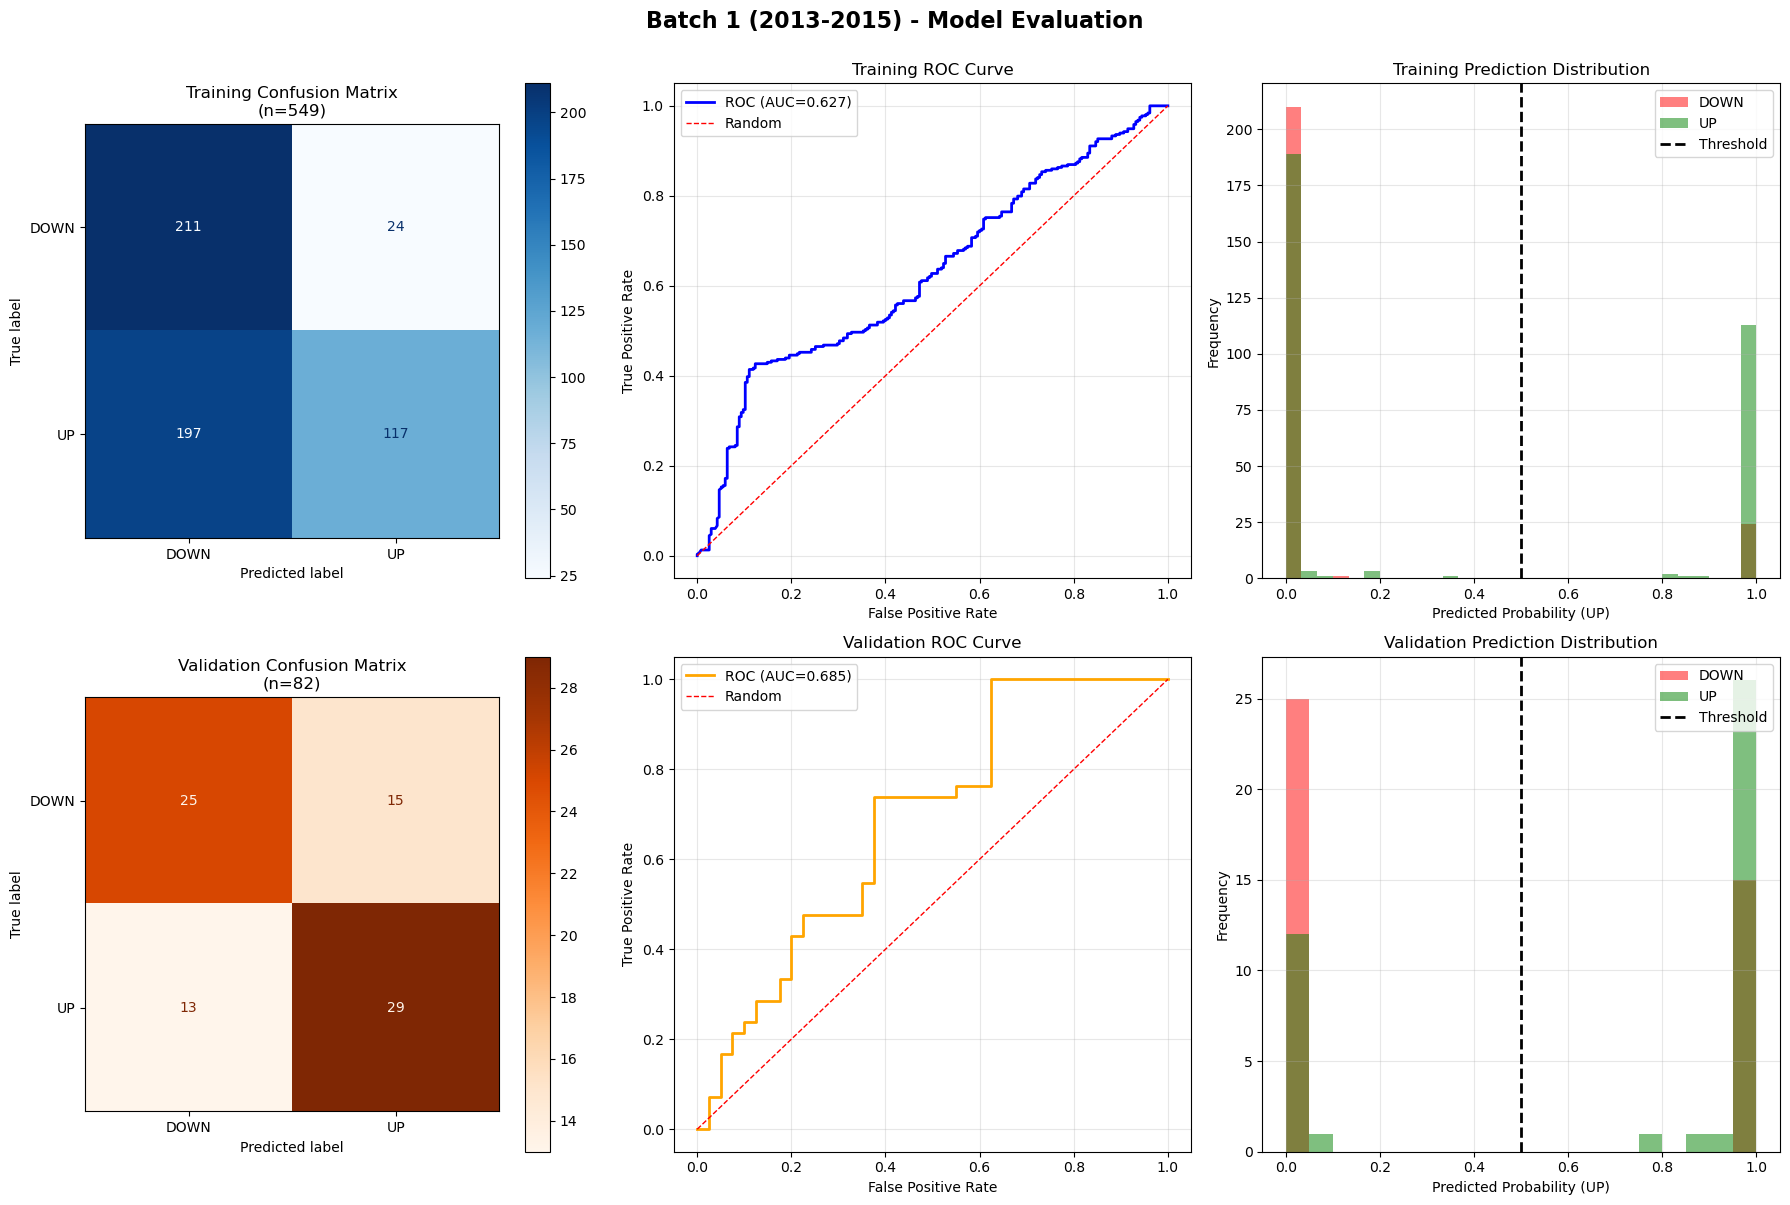


💾 Evaluation plot saved to: ..\models\finbert_lstm\batch_1_evaluation.png

--------------------------------------------------------------------------------


EVALUATING BATCH 2 (2016-2018)

📊 TRAINING SET METRICS:
   Samples: 595
   Accuracy:  0.5882 (58.82%)
   Precision: 0.9231
   Recall:    0.3820
   F1-Score:  0.5403
   AUC-ROC:   0.6858

📊 VALIDATION SET METRICS:
   Samples: 90
   Accuracy:  0.6111 (61.11%)
   Precision: 0.6957
   Recall:    0.3636
   F1-Score:  0.4776
   AUC-ROC:   0.5731

📋 TRAINING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.47      0.94      0.63       218
      UP (1)       0.92      0.38      0.54       377

    accuracy                           0.59       595
   macro avg       0.70      0.66      0.58       595
weighted avg       0.76      0.59      0.57       595


📋 VALIDATION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.58      0.85      0.69  

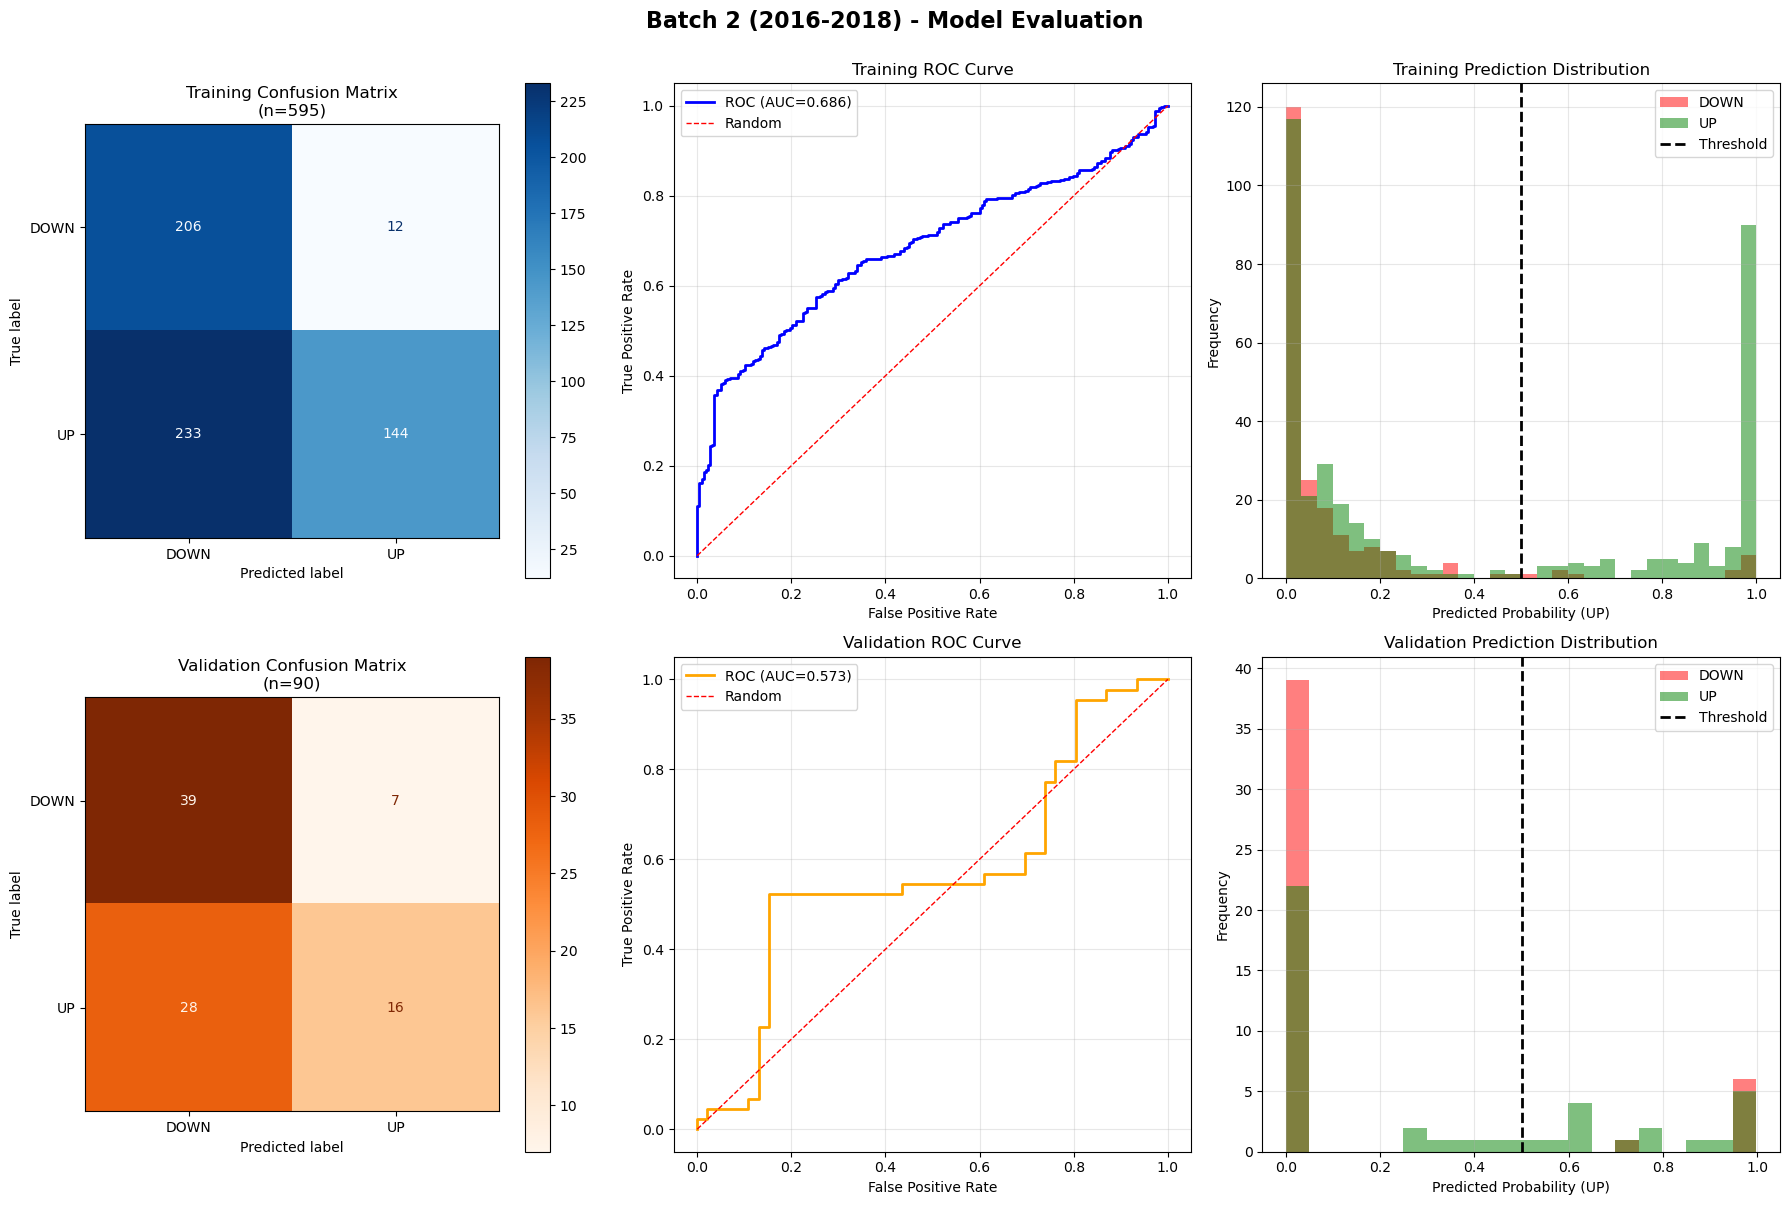


💾 Evaluation plot saved to: ..\models\finbert_lstm\batch_2_evaluation.png

--------------------------------------------------------------------------------


EVALUATING BATCH 3 (2019-2021)

📊 TRAINING SET METRICS:
   Samples: 604
   Accuracy:  0.6076 (60.76%)
   Precision: 0.9339
   Recall:    0.3304
   F1-Score:  0.4881
   AUC-ROC:   0.6067

📊 VALIDATION SET METRICS:
   Samples: 91
   Accuracy:  0.5275 (52.75%)
   Precision: 0.8947
   Recall:    0.2931
   F1-Score:  0.4416
   AUC-ROC:   0.6740

📋 TRAINING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.53      0.97      0.68       262
      UP (1)       0.93      0.33      0.49       342

    accuracy                           0.61       604
   macro avg       0.73      0.65      0.59       604
weighted avg       0.76      0.61      0.57       604


📋 VALIDATION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.43      0.94      0.59  

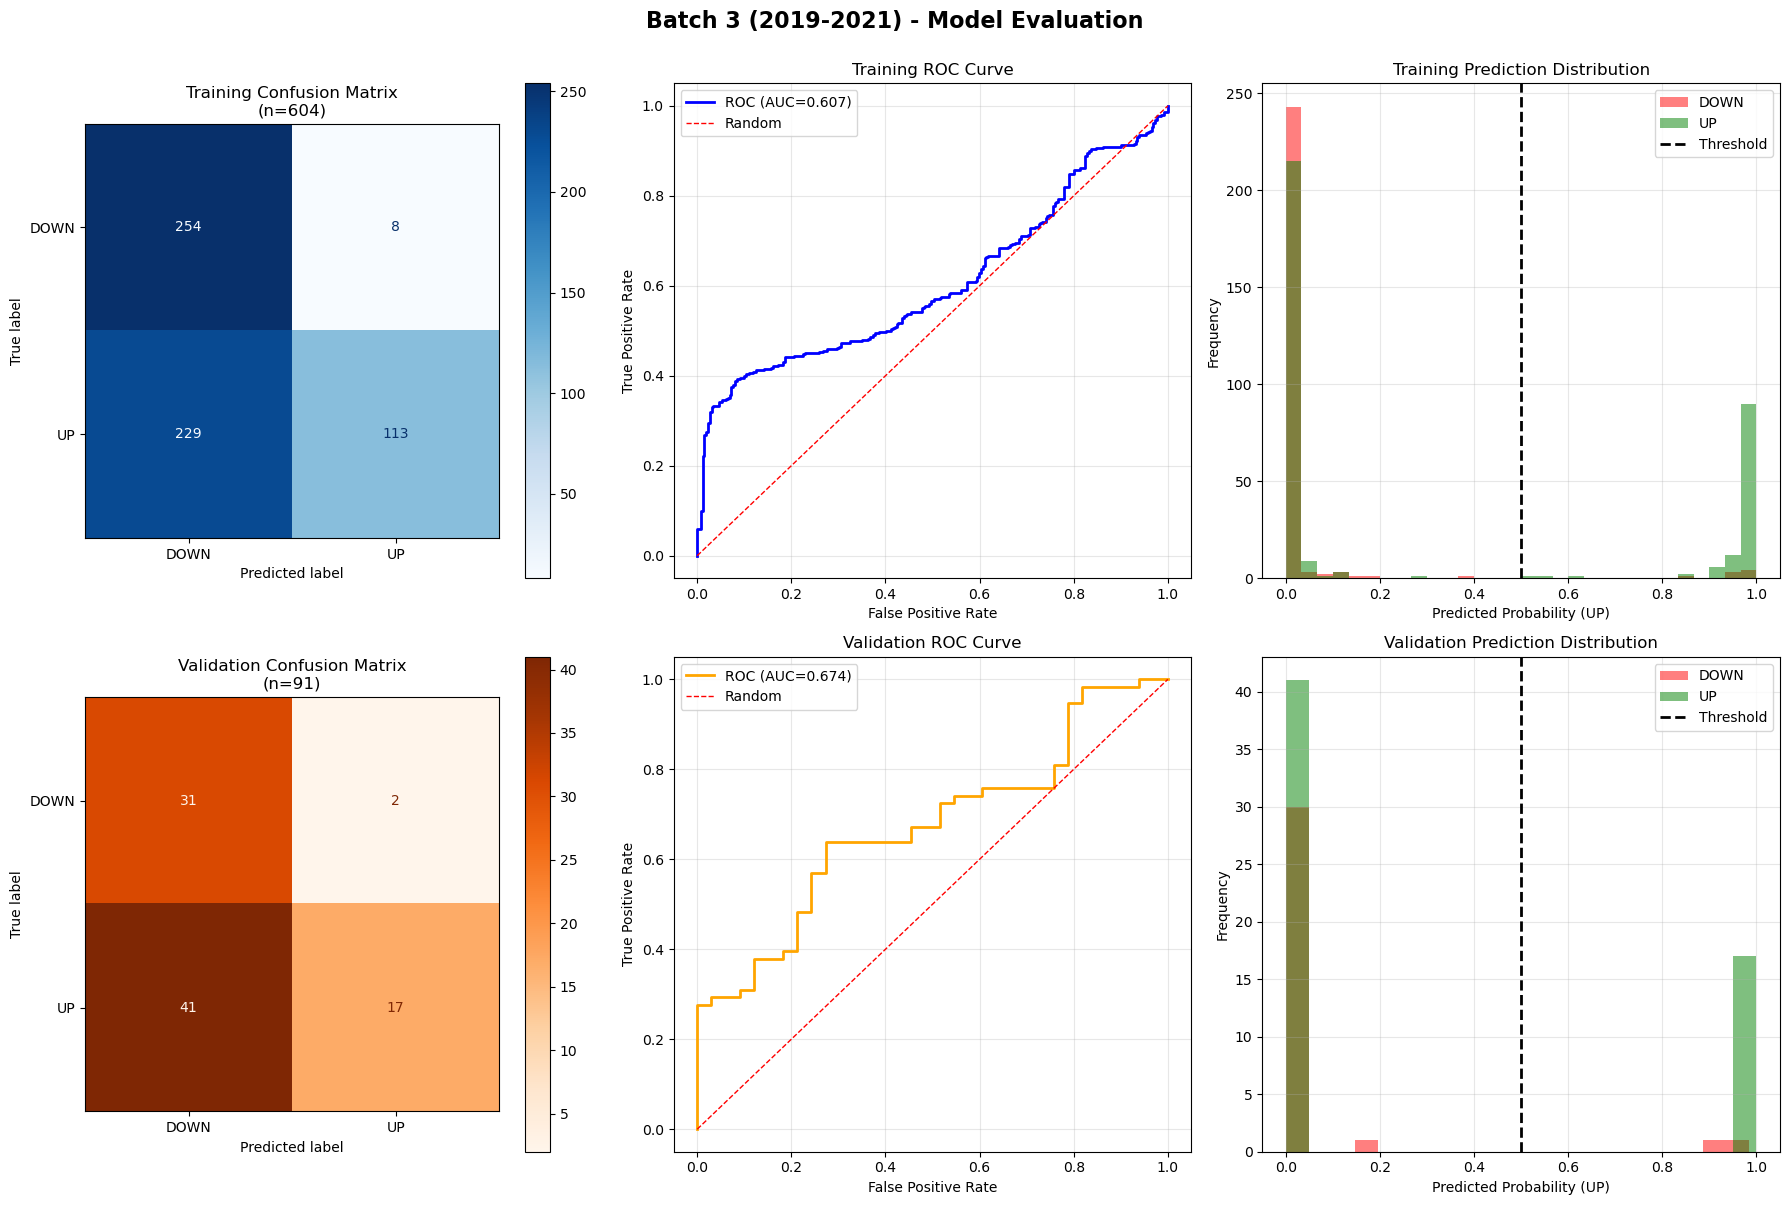


💾 Evaluation plot saved to: ..\models\finbert_lstm\batch_3_evaluation.png

--------------------------------------------------------------------------------


EVALUATING BATCH 4 (2022-2024)

📊 TRAINING SET METRICS:
   Samples: 602
   Accuracy:  0.5382 (53.82%)
   Precision: 0.7647
   Recall:    0.3259
   F1-Score:  0.4570
   AUC-ROC:   0.5114

📊 VALIDATION SET METRICS:
   Samples: 91
   Accuracy:  0.4835 (48.35%)
   Precision: 0.4835
   Recall:    1.0000
   F1-Score:  0.6519
   AUC-ROC:   0.5295

📋 TRAINING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.46      0.85      0.60       243
      UP (1)       0.76      0.33      0.46       359

    accuracy                           0.54       602
   macro avg       0.61      0.59      0.53       602
weighted avg       0.64      0.54      0.51       602


📋 VALIDATION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.00      0.00      0.00  

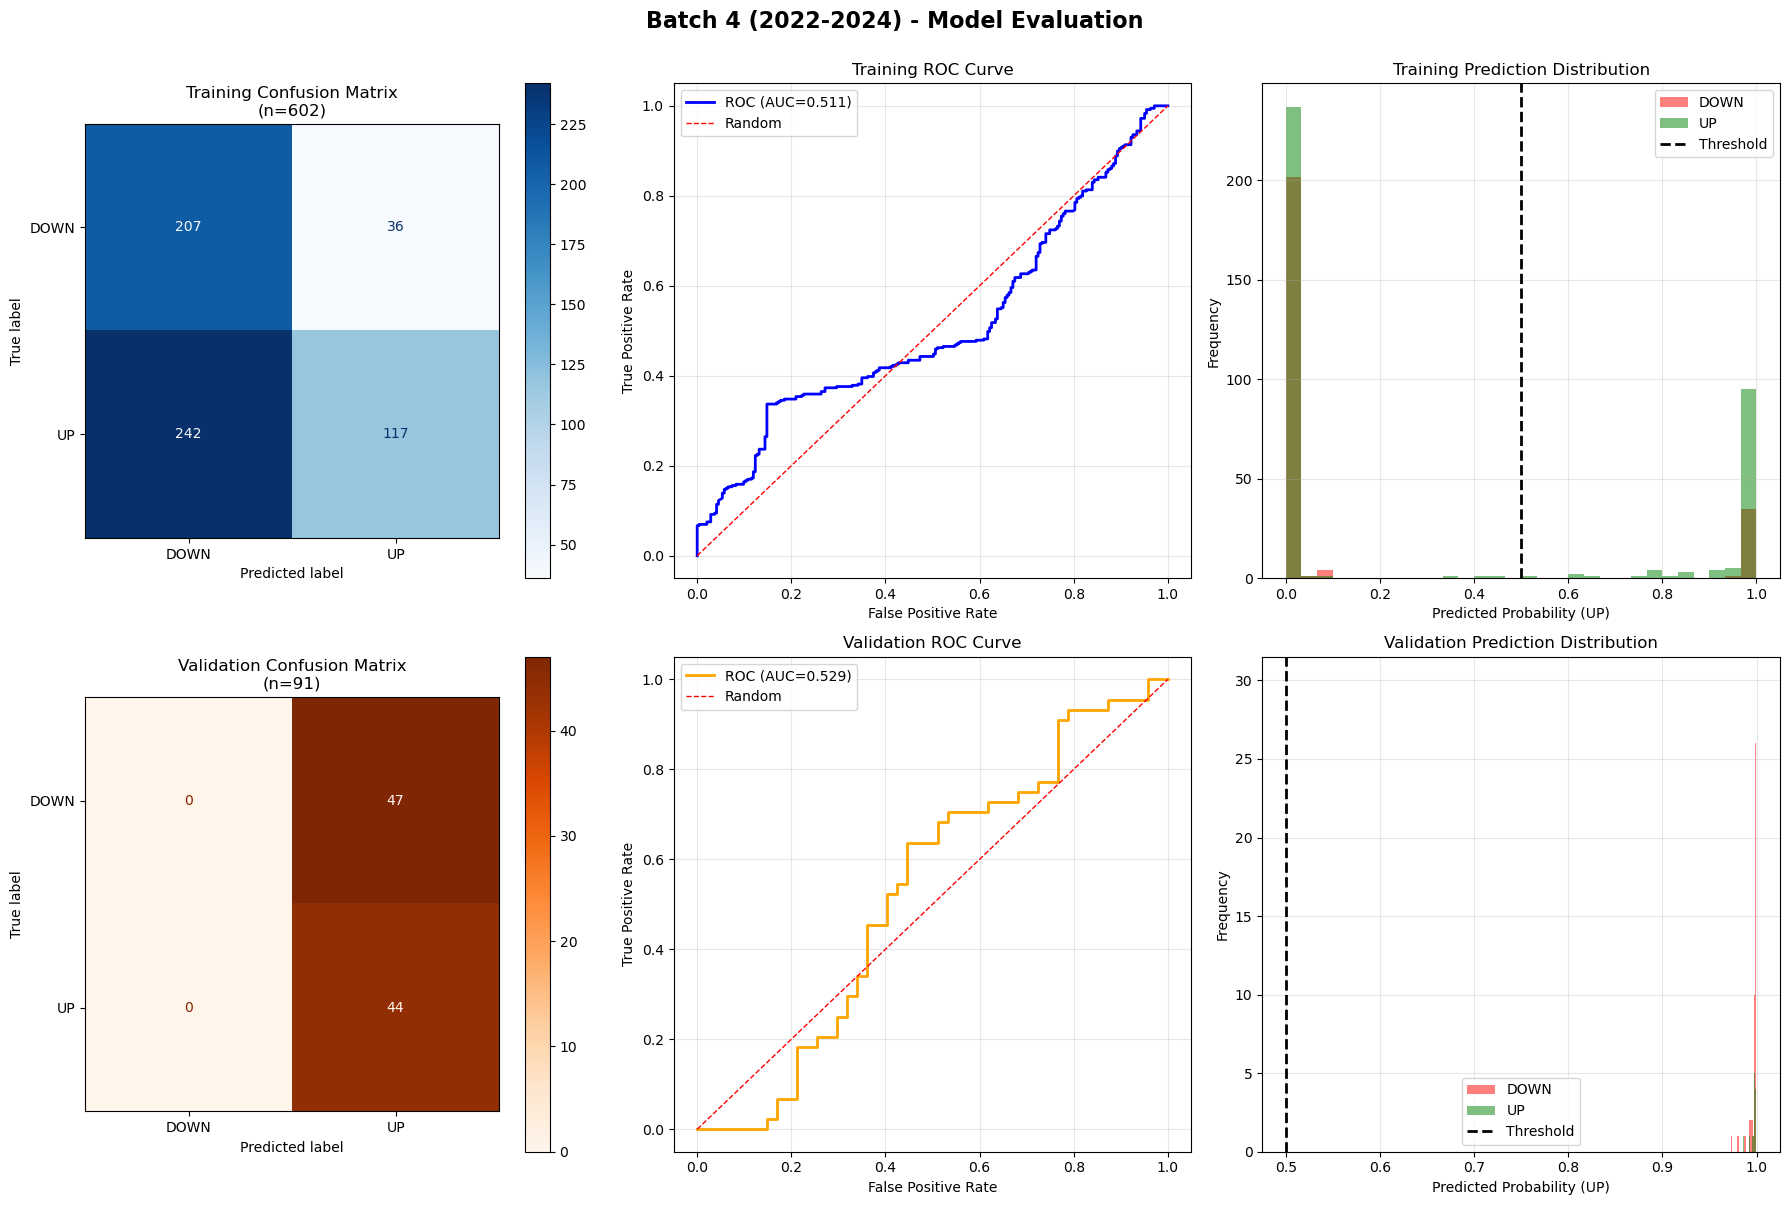


💾 Evaluation plot saved to: ..\models\finbert_lstm\batch_4_evaluation.png

--------------------------------------------------------------------------------


EVALUATING BATCH 5 (2025-2025)

📊 TRAINING SET METRICS:
   Samples: 100
   Accuracy:  0.6000 (60.00%)
   Precision: 0.9091
   Recall:    0.3448
   F1-Score:  0.5000
   AUC-ROC:   0.5587

📊 VALIDATION SET METRICS:
   Samples: 3
   Accuracy:  0.0000 (0.00%)
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   AUC-ROC:   0.0000

📋 TRAINING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.51      0.95      0.67        42
      UP (1)       0.91      0.34      0.50        58

    accuracy                           0.60       100
   macro avg       0.71      0.65      0.58       100
weighted avg       0.74      0.60      0.57       100


📋 VALIDATION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    DOWN (0)       0.00      0.00      0.00    

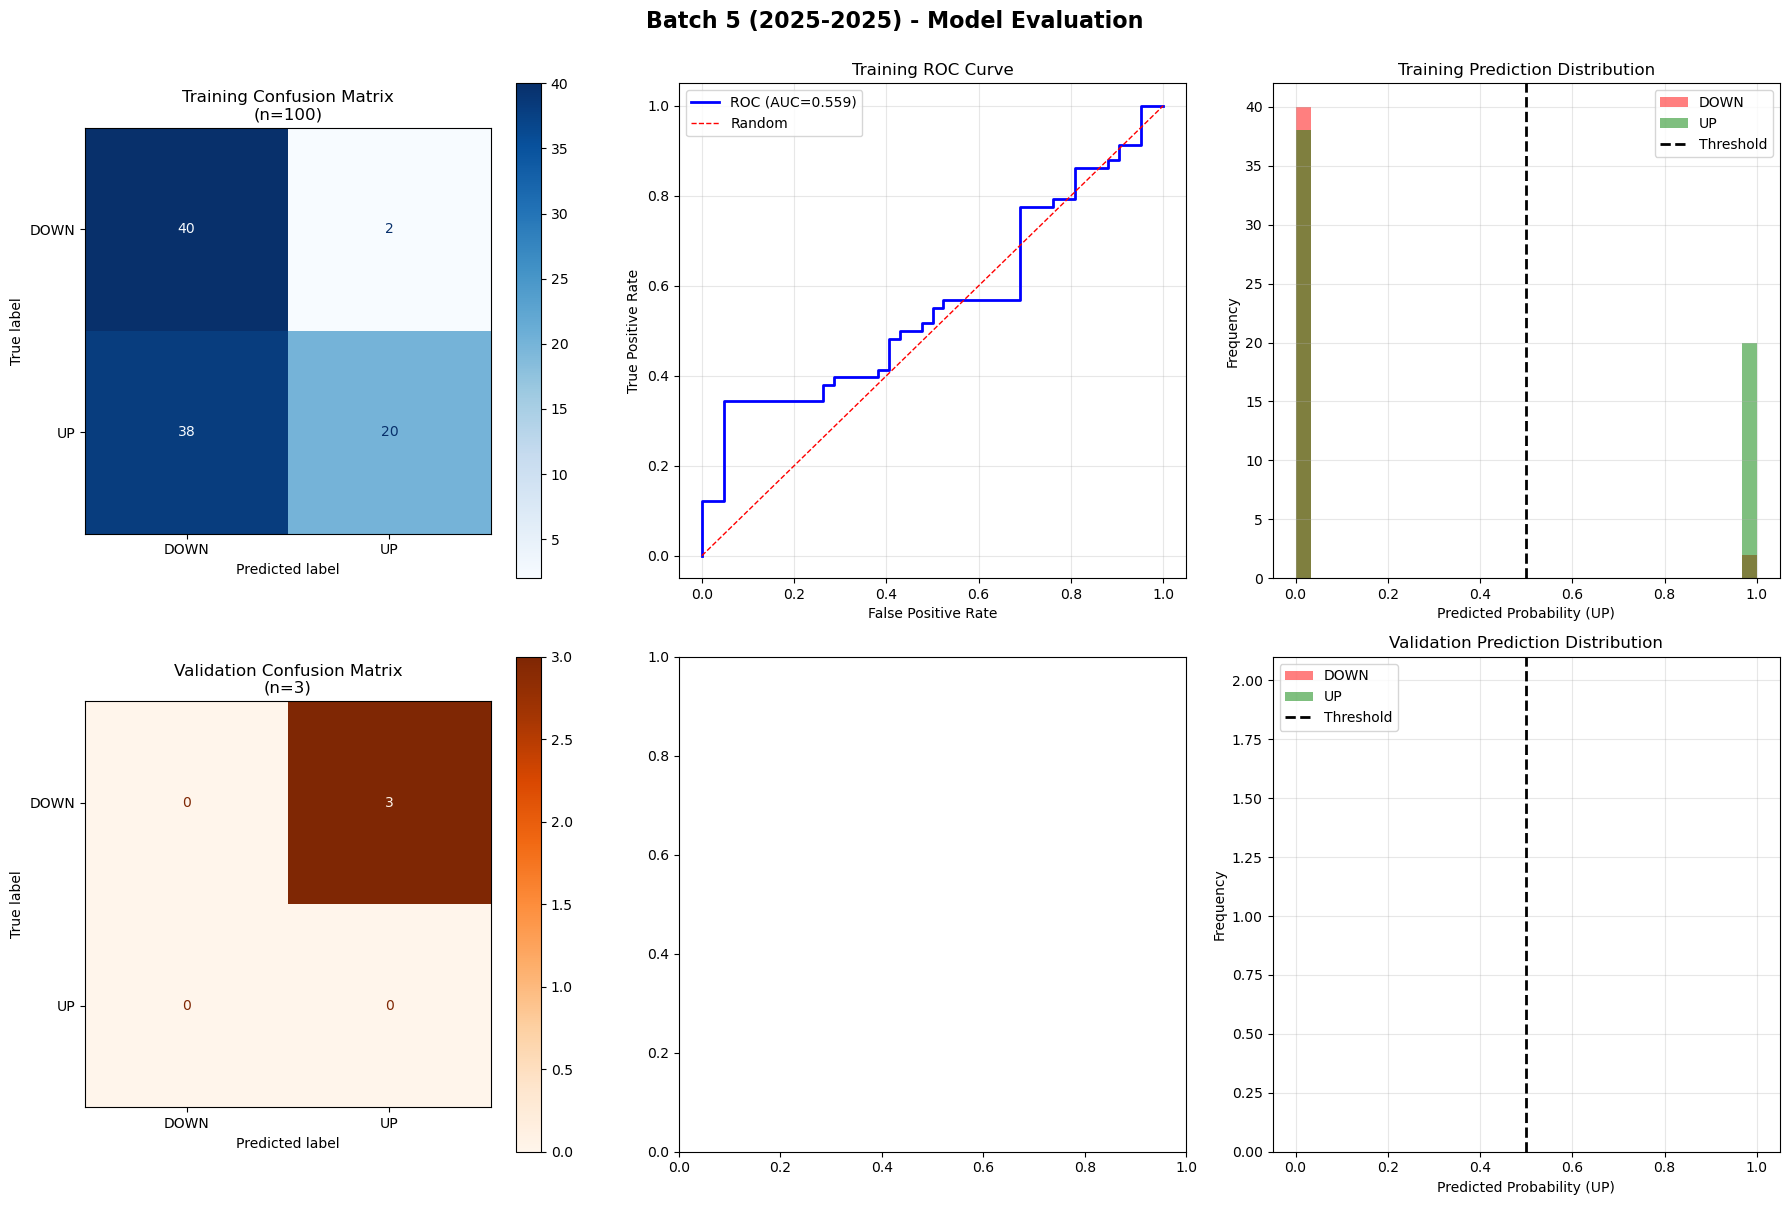


💾 Evaluation plot saved to: ..\models\finbert_lstm\batch_5_evaluation.png

ALL EVALUATIONS COMPLETE


In [30]:
# Evaluate all batches
print("\n" + "="*80)
print("EVALUATING ALL BATCH MODELS")
print("="*80)

all_evaluations = []

for i, (batch_result, processed_batch) in enumerate(zip(all_batch_results, processed_batches)):
    evaluation = evaluate_batch_model(
        batch_result=batch_result,
        processed_batch=processed_batch,
        batch_idx=processed_batch['batch_idx'],
        batch_years=processed_batch['years']
    )
    all_evaluations.append(evaluation)
    
    # Add separator between batches
    if i < len(all_batch_results) - 1:
        print("\n" + "-"*80 + "\n")

print("\n" + "="*80)
print("ALL EVALUATIONS COMPLETE")
print("="*80)

In [31]:
# Create comprehensive comparison table
print("\n" + "="*80)
print("COMPREHENSIVE METRICS COMPARISON - ALL BATCHES")
print("="*80)

# Create comparison DataFrame
comparison_data = []

for eval_result in all_evaluations:
    comparison_data.append({
        'Batch': f"{eval_result['batch_idx']+1} ({eval_result['batch_years']})",
        'Train Acc': f"{eval_result['train_metrics']['accuracy']:.4f}",
        'Train AUC': f"{eval_result['train_metrics']['auc']:.4f}",
        'Train F1': f"{eval_result['train_metrics']['f1']:.4f}",
        'Val Acc': f"{eval_result['val_metrics']['accuracy']:.4f}",
        'Val AUC': f"{eval_result['val_metrics']['auc']:.4f}",
        'Val F1': f"{eval_result['val_metrics']['f1']:.4f}",
        'Val Precision': f"{eval_result['val_metrics']['precision']:.4f}",
        'Val Recall': f"{eval_result['val_metrics']['recall']:.4f}",
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Performance Metrics Table:")
print(comparison_df.to_string(index=False))

# Find best models
best_val_auc_idx = comparison_df['Val AUC'].astype(float).idxmax()
best_val_acc_idx = comparison_df['Val Acc'].astype(float).idxmax()
best_val_f1_idx = comparison_df['Val F1'].astype(float).idxmax()

print(f"\n🏆 BEST PERFORMERS:")
print(f"   Highest Val AUC:     {comparison_df.loc[best_val_auc_idx, 'Batch']} - {comparison_df.loc[best_val_auc_idx, 'Val AUC']}")
print(f"   Highest Val Accuracy: {comparison_df.loc[best_val_acc_idx, 'Batch']} - {comparison_df.loc[best_val_acc_idx, 'Val Acc']}")
print(f"   Highest Val F1:      {comparison_df.loc[best_val_f1_idx, 'Batch']} - {comparison_df.loc[best_val_f1_idx, 'Val F1']}")

# Save comparison table
comparison_file = MODEL_DIR / 'batch_metrics_comparison.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"\n💾 Comparison table saved to: {comparison_file}")

# Save detailed evaluation results
eval_results_file = MODEL_DIR / 'detailed_evaluation_results.json'
with open(eval_results_file, 'w') as f:
    json.dump(all_evaluations, f, indent=2)
print(f"💾 Detailed results saved to: {eval_results_file}")

print("\n" + "="*80)


COMPREHENSIVE METRICS COMPARISON - ALL BATCHES

📊 Performance Metrics Table:
        Batch Train Acc Train AUC Train F1 Val Acc Val AUC Val F1 Val Precision Val Recall
1 (2013-2015)    0.5974    0.6274   0.5143  0.6585  0.6851 0.6744        0.6591     0.6905
2 (2016-2018)    0.5882    0.6858   0.5403  0.6111  0.5731 0.4776        0.6957     0.3636
3 (2019-2021)    0.6076    0.6067   0.4881  0.5275  0.6740 0.4416        0.8947     0.2931
4 (2022-2024)    0.5382    0.5114   0.4570  0.4835  0.5295 0.6519        0.4835     1.0000
5 (2025-2025)    0.6000    0.5587   0.5000  0.0000  0.0000 0.0000        0.0000     0.0000

🏆 BEST PERFORMERS:
   Highest Val AUC:     1 (2013-2015) - 0.6851
   Highest Val Accuracy: 1 (2013-2015) - 0.6585
   Highest Val F1:      1 (2013-2015) - 0.6744

💾 Comparison table saved to: ..\models\finbert_lstm\batch_metrics_comparison.csv
💾 Detailed results saved to: ..\models\finbert_lstm\detailed_evaluation_results.json



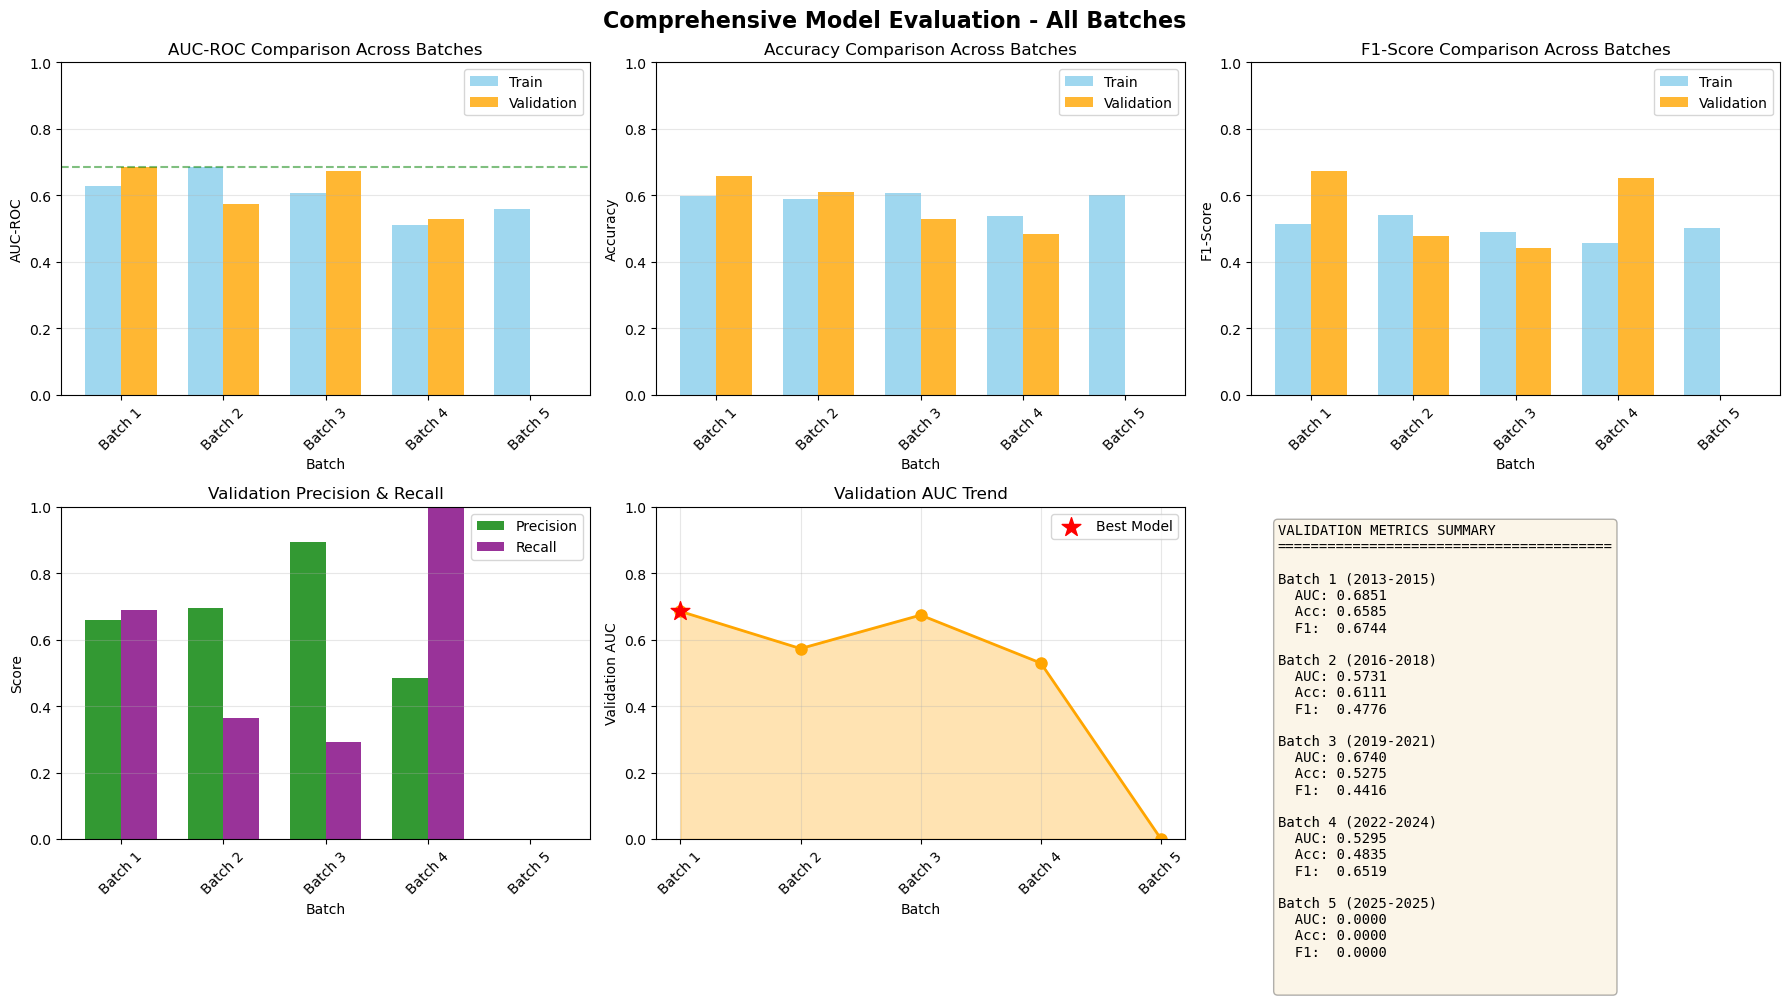


💾 Summary visualization saved to: ..\models\finbert_lstm\all_batches_evaluation_summary.png

✅ All evaluations complete!


In [32]:
# Create summary visualization comparing all batches
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

batches_labels = [f"Batch {e['batch_idx']+1}" for e in all_evaluations]
train_aucs = [e['train_metrics']['auc'] for e in all_evaluations]
val_aucs = [e['val_metrics']['auc'] for e in all_evaluations]
train_accs = [e['train_metrics']['accuracy'] for e in all_evaluations]
val_accs = [e['val_metrics']['accuracy'] for e in all_evaluations]
train_f1s = [e['train_metrics']['f1'] for e in all_evaluations]
val_f1s = [e['val_metrics']['f1'] for e in all_evaluations]

x_pos = np.arange(len(batches_labels))
width = 0.35

# AUC Comparison
axes[0, 0].bar(x_pos - width/2, train_aucs, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 0].bar(x_pos + width/2, val_aucs, width, label='Validation', alpha=0.8, color='orange')
axes[0, 0].set_xlabel('Batch')
axes[0, 0].set_ylabel('AUC-ROC')
axes[0, 0].set_title('AUC-ROC Comparison Across Batches')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(batches_labels, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1])

# Highlight best
best_val_auc_batch = np.argmax(val_aucs)
axes[0, 0].axhline(y=val_aucs[best_val_auc_batch], color='green', linestyle='--', 
                   alpha=0.5, label=f'Best: {val_aucs[best_val_auc_batch]:.4f}')

# Accuracy Comparison
axes[0, 1].bar(x_pos - width/2, train_accs, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 1].bar(x_pos + width/2, val_accs, width, label='Validation', alpha=0.8, color='orange')
axes[0, 1].set_xlabel('Batch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy Comparison Across Batches')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(batches_labels, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 1])

# F1 Score Comparison
axes[0, 2].bar(x_pos - width/2, train_f1s, width, label='Train', alpha=0.8, color='skyblue')
axes[0, 2].bar(x_pos + width/2, val_f1s, width, label='Validation', alpha=0.8, color='orange')
axes[0, 2].set_xlabel('Batch')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_title('F1-Score Comparison Across Batches')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(batches_labels, rotation=45)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')
axes[0, 2].set_ylim([0, 1])

# Precision & Recall Comparison
val_precisions = [e['val_metrics']['precision'] for e in all_evaluations]
val_recalls = [e['val_metrics']['recall'] for e in all_evaluations]

axes[1, 0].bar(x_pos - width/2, val_precisions, width, label='Precision', alpha=0.8, color='green')
axes[1, 0].bar(x_pos + width/2, val_recalls, width, label='Recall', alpha=0.8, color='purple')
axes[1, 0].set_xlabel('Batch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation Precision & Recall')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(batches_labels, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([0, 1])

# Validation AUC Trend
axes[1, 1].plot(x_pos, val_aucs, marker='o', linewidth=2, markersize=8, color='orange')
axes[1, 1].fill_between(x_pos, val_aucs, alpha=0.3, color='orange')
axes[1, 1].set_xlabel('Batch')
axes[1, 1].set_ylabel('Validation AUC')
axes[1, 1].set_title('Validation AUC Trend')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(batches_labels, rotation=45)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

# Highlight best performing batch
best_idx = np.argmax(val_aucs)
axes[1, 1].scatter([best_idx], [val_aucs[best_idx]], s=200, c='red', 
                   marker='*', zorder=5, label='Best Model')
axes[1, 1].legend()

# Summary Statistics Table
summary_text = "VALIDATION METRICS SUMMARY\n" + "="*40 + "\n\n"
for i, eval_result in enumerate(all_evaluations):
    batch_label = f"Batch {eval_result['batch_idx']+1} ({eval_result['batch_years']})"
    summary_text += f"{batch_label}\n"
    summary_text += f"  AUC: {eval_result['val_metrics']['auc']:.4f}\n"
    summary_text += f"  Acc: {eval_result['val_metrics']['accuracy']:.4f}\n"
    summary_text += f"  F1:  {eval_result['val_metrics']['f1']:.4f}\n\n"

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
axes[1, 2].axis('off')

plt.suptitle('Comprehensive Model Evaluation - All Batches', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

# Save
summary_plot = MODEL_DIR / 'all_batches_evaluation_summary.png'
plt.savefig(summary_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Summary visualization saved to: {summary_plot}")
print("\n✅ All evaluations complete!")